In [2]:
# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Print versions
from importlib.metadata import version
print("=== Environment Check ===")
print(f"Scanpy version: {version('scanpy')}")
print(f"Pandas version: {version('pandas')}")
print(f"NumPy version: {version('numpy')}")
print(f"Working directory: {os.getcwd()}")

=== Environment Check ===
Scanpy version: 1.11.5
Pandas version: 3.0.0
NumPy version: 2.3.5
Working directory: c:\Users\manju\OneDrive\Documents\cancer-evolution\notebooks


In [3]:
# Verify File Exists 
import os
import scanpy as sc

# go up one directory from notebooks/
data_path = "../data/raw/breast_cancer.h5"

# Verify file exists
if os.path.exists(data_path):
    file_size = os.path.getsize(data_path) / (1024 * 1024)
    print(f"✓ Dataset found!")
    print(f"  Path: {data_path}")
    print(f"  Full path: {os.path.abspath(data_path)}")
    print(f"  File size: {file_size:.2f} MB")
    print(f"  Ready to load in next cell!")
else:
    print(f"❌ File not found at: {data_path}")
    print(f"   Full path checked: {os.path.abspath(data_path)}")
    print(f"   The issue is the path in your code.")



✓ Dataset found!
  Path: ../data/raw/breast_cancer.h5
  Full path: c:\Users\manju\OneDrive\Documents\cancer-evolution\data\raw\breast_cancer.h5
  File size: 27.12 MB
  Ready to load in next cell!


In [4]:
#Load and inspect data
import scanpy as sc

print("Loading dataset...")
adata = sc.read_10x_h5("../data/raw/breast_cancer.h5")

# Make gene names unique
adata.var_names_make_unique()

print("\n=== DATASET OVERVIEW ===")
print(f"Number of cells: {adata.n_obs:,}")
print(f"Number of genes: {adata.n_vars:,}")
print(f"\nFirst 5 genes:\n{adata.var_names[:5].tolist()}")
print(f"\nData matrix shape: {adata.X.shape}")


Loading dataset...


c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\anndata\_core\anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\anndata\_core\anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")



=== DATASET OVERVIEW ===
Number of cells: 4,992
Number of genes: 33,538

First 5 genes:
['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']

Data matrix shape: (4992, 33538)



=== QUALITY CONTROL ===

QC Metrics Summary:
Mean counts per cell: 15152.92
Median counts per cell: 12388.00
Mean genes per cell: 4292.14
Median genes per cell: 4428.00

Mean mitochondrial percentage: 4.92%
Median mitochondrial percentage: 4.21%


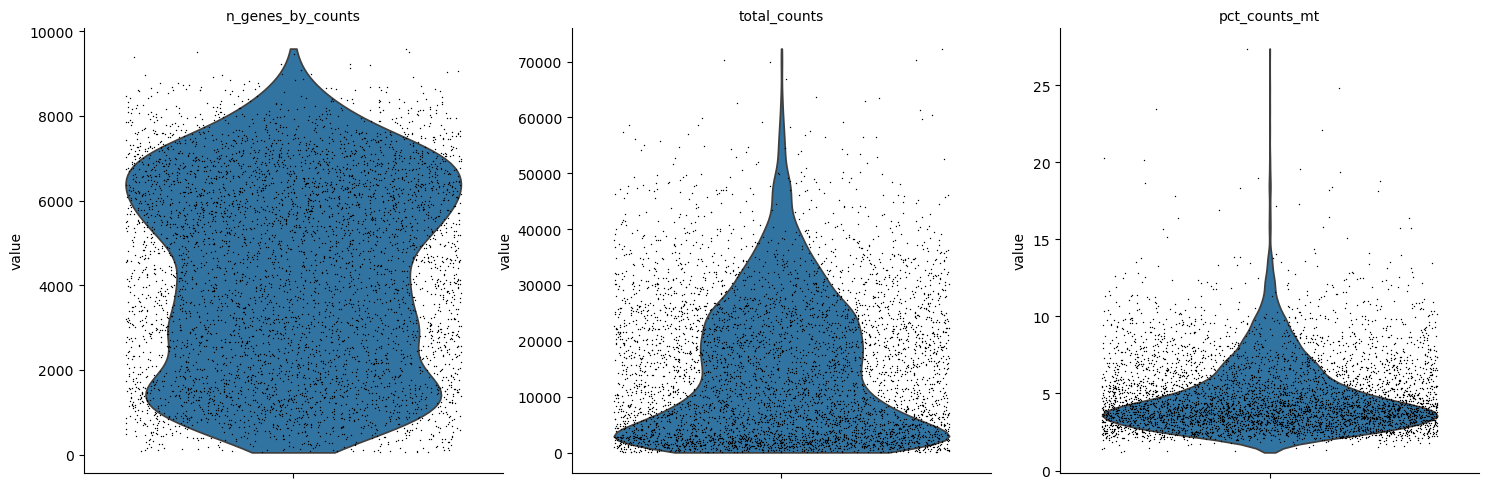

In [5]:
# Basic preprocessing and quality control

print("\n=== QUALITY CONTROL ===")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Print QC summary statistics
print(f"\nQC Metrics Summary:")
print(f"Mean counts per cell: {adata.obs['total_counts'].mean():.2f}")
print(f"Median counts per cell: {adata.obs['total_counts'].median():.2f}")
print(f"Mean genes per cell: {adata.obs['n_genes_by_counts'].mean():.2f}")
print(f"Median genes per cell: {adata.obs['n_genes_by_counts'].median():.2f}")

# Calculate mitochondrial gene percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(f"\nMean mitochondrial percentage: {adata.obs['pct_counts_mt'].mean():.2f}%")
print(f"Median mitochondrial percentage: {adata.obs['pct_counts_mt'].median():.2f}%")

# Visualize QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [6]:
# Conservative filtering based on QC metrics

print("\n=== FILTERING ===")
print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Save original counts
n_cells_before = adata.n_obs
n_genes_before = adata.n_vars

# Filter cells with too few genes
sc.pp.filter_cells(adata, min_genes=500)

# Filter genes detected in too few cells
sc.pp.filter_genes(adata, min_cells=3)

# Filter based on total counts
# Lower: Remove bottom 5% (median is 12,388, so ~3,000 is safe)
# Upper: Remove top outliers (3x median = ~37,000)
adata = adata[adata.obs['total_counts'] > 3000, :]
adata = adata[adata.obs['total_counts'] < 40000, :]

# Filter based on number of genes
# Lower: Remove cells with <25% of median genes (4428 * 0.25 ≈ 1100)
# Upper: Remove cells with >2x median genes (4428 * 2 ≈ 8850)
adata = adata[adata.obs['n_genes_by_counts'] > 1100, :]
adata = adata[adata.obs['n_genes_by_counts'] < 8800, :]

# Filter cells with high mitochondrial content
# Your median is 4.21%, so 15% catches dying cells while keeping healthy ones
adata = adata[adata.obs['pct_counts_mt'] < 15, :]

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")
print(f"Removed {n_cells_before - adata.n_obs} cells ({((n_cells_before - adata.n_obs) / n_cells_before * 100):.1f}%)")
print(f"Removed {n_genes_before - adata.n_vars} genes")


=== FILTERING ===
Before filtering: 4992 cells, 33538 genes
After filtering: 3821 cells, 20814 genes
Removed 1171 cells (23.5%)
Removed 12724 genes


In [7]:
# Normalization and log transformation

print("\n=== NORMALIZATION ===")

# Normalize total counts per cell to 10,000
# Makes cells comparable by accounting for sequencing depth differences
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform (log(x+1)) to stabilize variance
sc.pp.log1p(adata)

print("Normalization complete!")
print(f"Data is now normalized and log-transformed")

# Store raw counts before further processing (for DE analysis later)
adata.raw = adata


=== NORMALIZATION ===


c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Normalization complete!
Data is now normalized and log-transformed



=== FEATURE SELECTION ===
Highly variable genes identified: 2000
Total genes in dataset: 20814


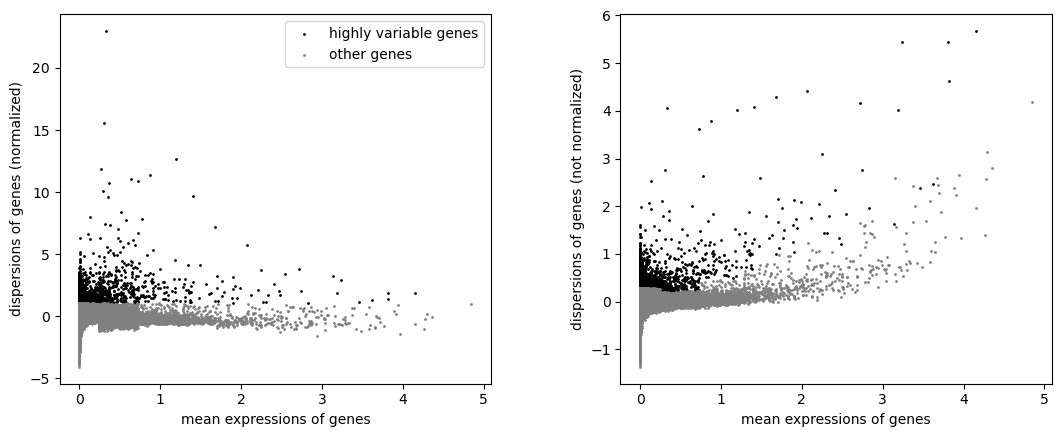


Filtered to 2000 highly variable genes for clustering


In [8]:
# Identify highly variable genes

print("\n=== FEATURE SELECTION ===")

# Identify highly variable genes (HVGs)
# These are genes that vary most across cells (biologically interesting)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

print(f"Highly variable genes identified: {adata.var['highly_variable'].sum()}")
print(f"Total genes in dataset: {adata.n_vars}")

# Visualize highly variable genes
sc.pl.highly_variable_genes(adata)

# Filter to keep only highly variable genes for downstream analysis
adata_hvg = adata[:, adata.var['highly_variable']]

print(f"\nFiltered to {adata_hvg.n_vars} highly variable genes for clustering")


=== SCALING AND PCA ===


c:\Users\manju\miniconda3\envs\cancer-sc\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Data scaled successfully
PCA complete: 50 components computed


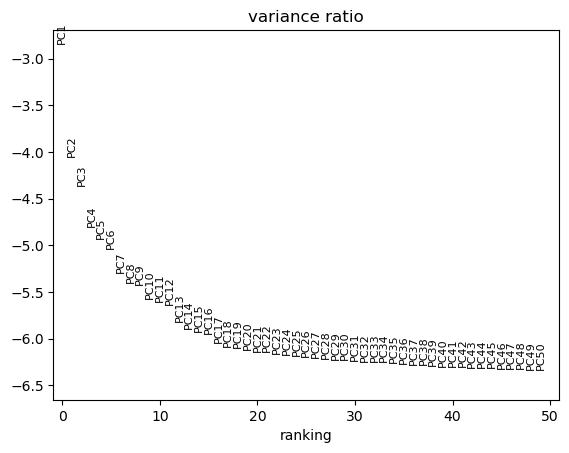


Variance explained by first 10 PCs: 12.85%
Variance explained by first 30 PCs: 17.64%


In [9]:
# Scale data and perform PCA

print("\n=== SCALING AND PCA ===")

# Scale data to unit variance and zero mean
# This prevents highly expressed genes from dominating
sc.pp.scale(adata, max_value=10)

print("Data scaled successfully")

# Perform PCA (Principal Component Analysis)
# Reduces 2000 HVGs down to 50 principal components
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print(f"PCA complete: {adata.obsm['X_pca'].shape[1]} components computed")

# Visualize variance explained by each PC
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

# Check how many PCs capture most variance
print(f"\nVariance explained by first 10 PCs: {adata.uns['pca']['variance_ratio'][:10].sum():.2%}")
print(f"Variance explained by first 30 PCs: {adata.uns['pca']['variance_ratio'][:30].sum():.2%}")


=== COMPUTING NEIGHBORHOOD GRAPH ===


c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Neighborhood graph computed
Using 15 nearest neighbors and 30 principal components

=== COMPUTING UMAP ===
UMAP embedding computed


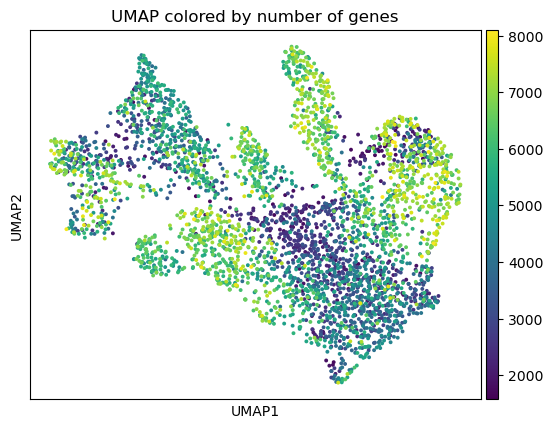

In [10]:
# Neighborhood graph and UMAP

print("\n=== COMPUTING NEIGHBORHOOD GRAPH ===")

# Compute neighborhood graph based on PCA
# Finds k-nearest neighbors for each cell in PCA space
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

print("Neighborhood graph computed")
print(f"Using {15} nearest neighbors and {30} principal components")

print("\n=== COMPUTING UMAP ===")

# Compute UMAP (Uniform Manifold Approximation and Projection)
# Projects high-dimensional data into 2D for visualization
sc.tl.umap(adata)

print("UMAP embedding computed")

# Visualize UMAP (basic, no coloring yet)
sc.pl.umap(adata, color='n_genes_by_counts', 
           title='UMAP colored by number of genes')


=== LEIDEN CLUSTERING ===


C:\Users\manju\AppData\Local\Temp\ipykernel_29076\945135993.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


Leiden clustering complete
Number of clusters identified: 9

Cluster sizes:
leiden
0    822
1    556
2    535
3    515
4    417
5    406
6    326
7    207
8     37
Name: count, dtype: int64


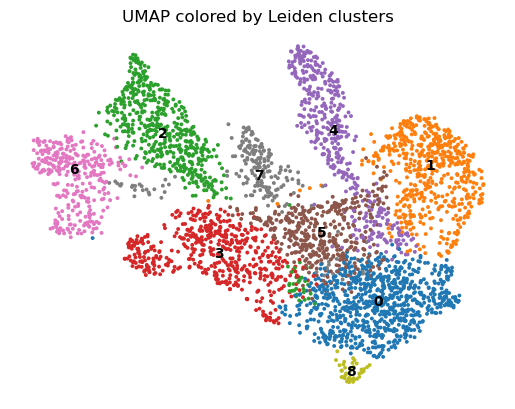

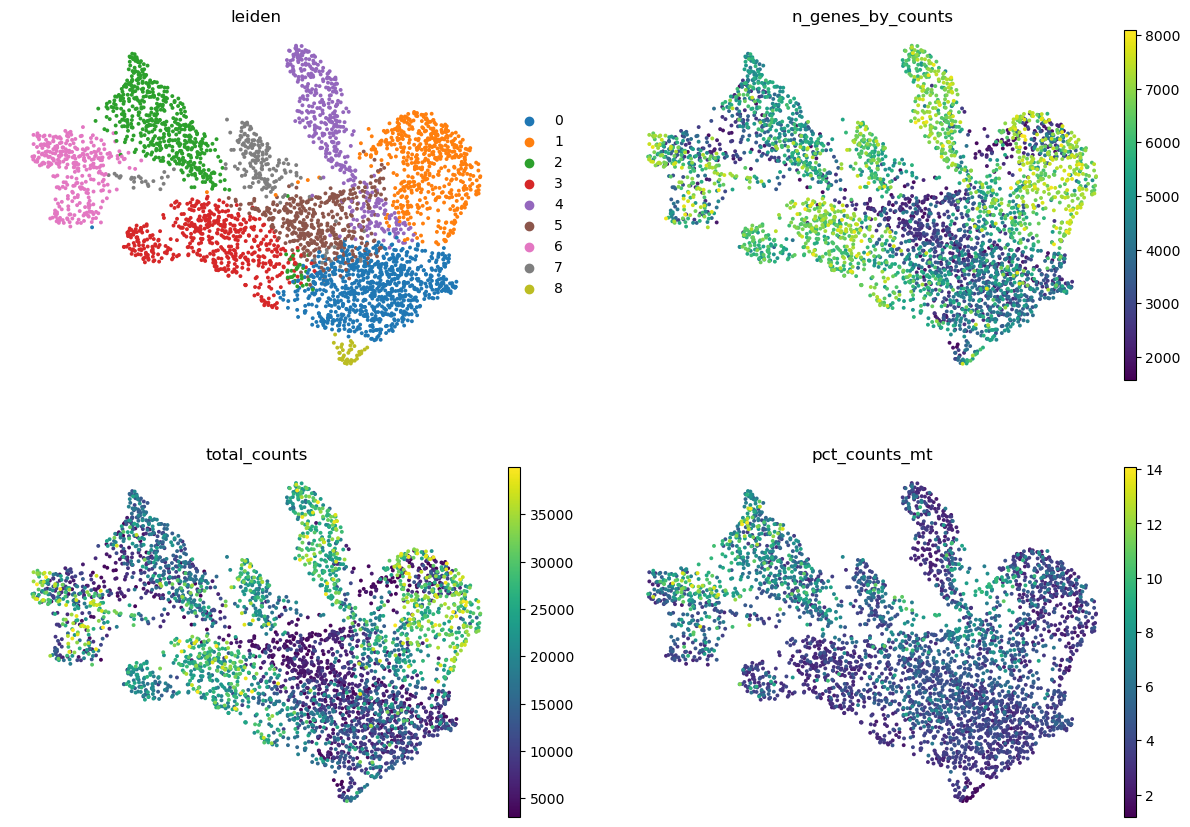

In [11]:
# Leiden clustering

print("\n=== LEIDEN CLUSTERING ===")

# Perform Leiden clustering
# Resolution controls granularity: higher = more clusters
sc.tl.leiden(adata, resolution=0.5)

print(f"Leiden clustering complete")
print(f"Number of clusters identified: {adata.obs['leiden'].nunique()}")

# Print cluster sizes
print("\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

# Visualize clusters on UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data', 
           title='UMAP colored by Leiden clusters', 
           frameon=False, legend_fontsize=10)

# Also visualize with other QC metrics to check cluster quality
sc.pl.umap(adata, color=['leiden', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
           ncols=2, frameon=False)

In [12]:
# Quick QC check for cluster 8
print("\n=== Cluster 8 QC Check ===")
cluster_8 = adata[adata.obs['leiden'] == '8']
print(f"Mean genes: {cluster_8.obs['n_genes_by_counts'].mean():.0f}")
print(f"Mean counts: {cluster_8.obs['total_counts'].mean():.0f}")
print(f"Mean MT%: {cluster_8.obs['pct_counts_mt'].mean():.2f}%")


=== Cluster 8 QC Check ===
Mean genes: 4205
Mean counts: 11535
Mean MT%: 2.58%



=== FINDING MARKER GENES ===
Marker gene analysis complete


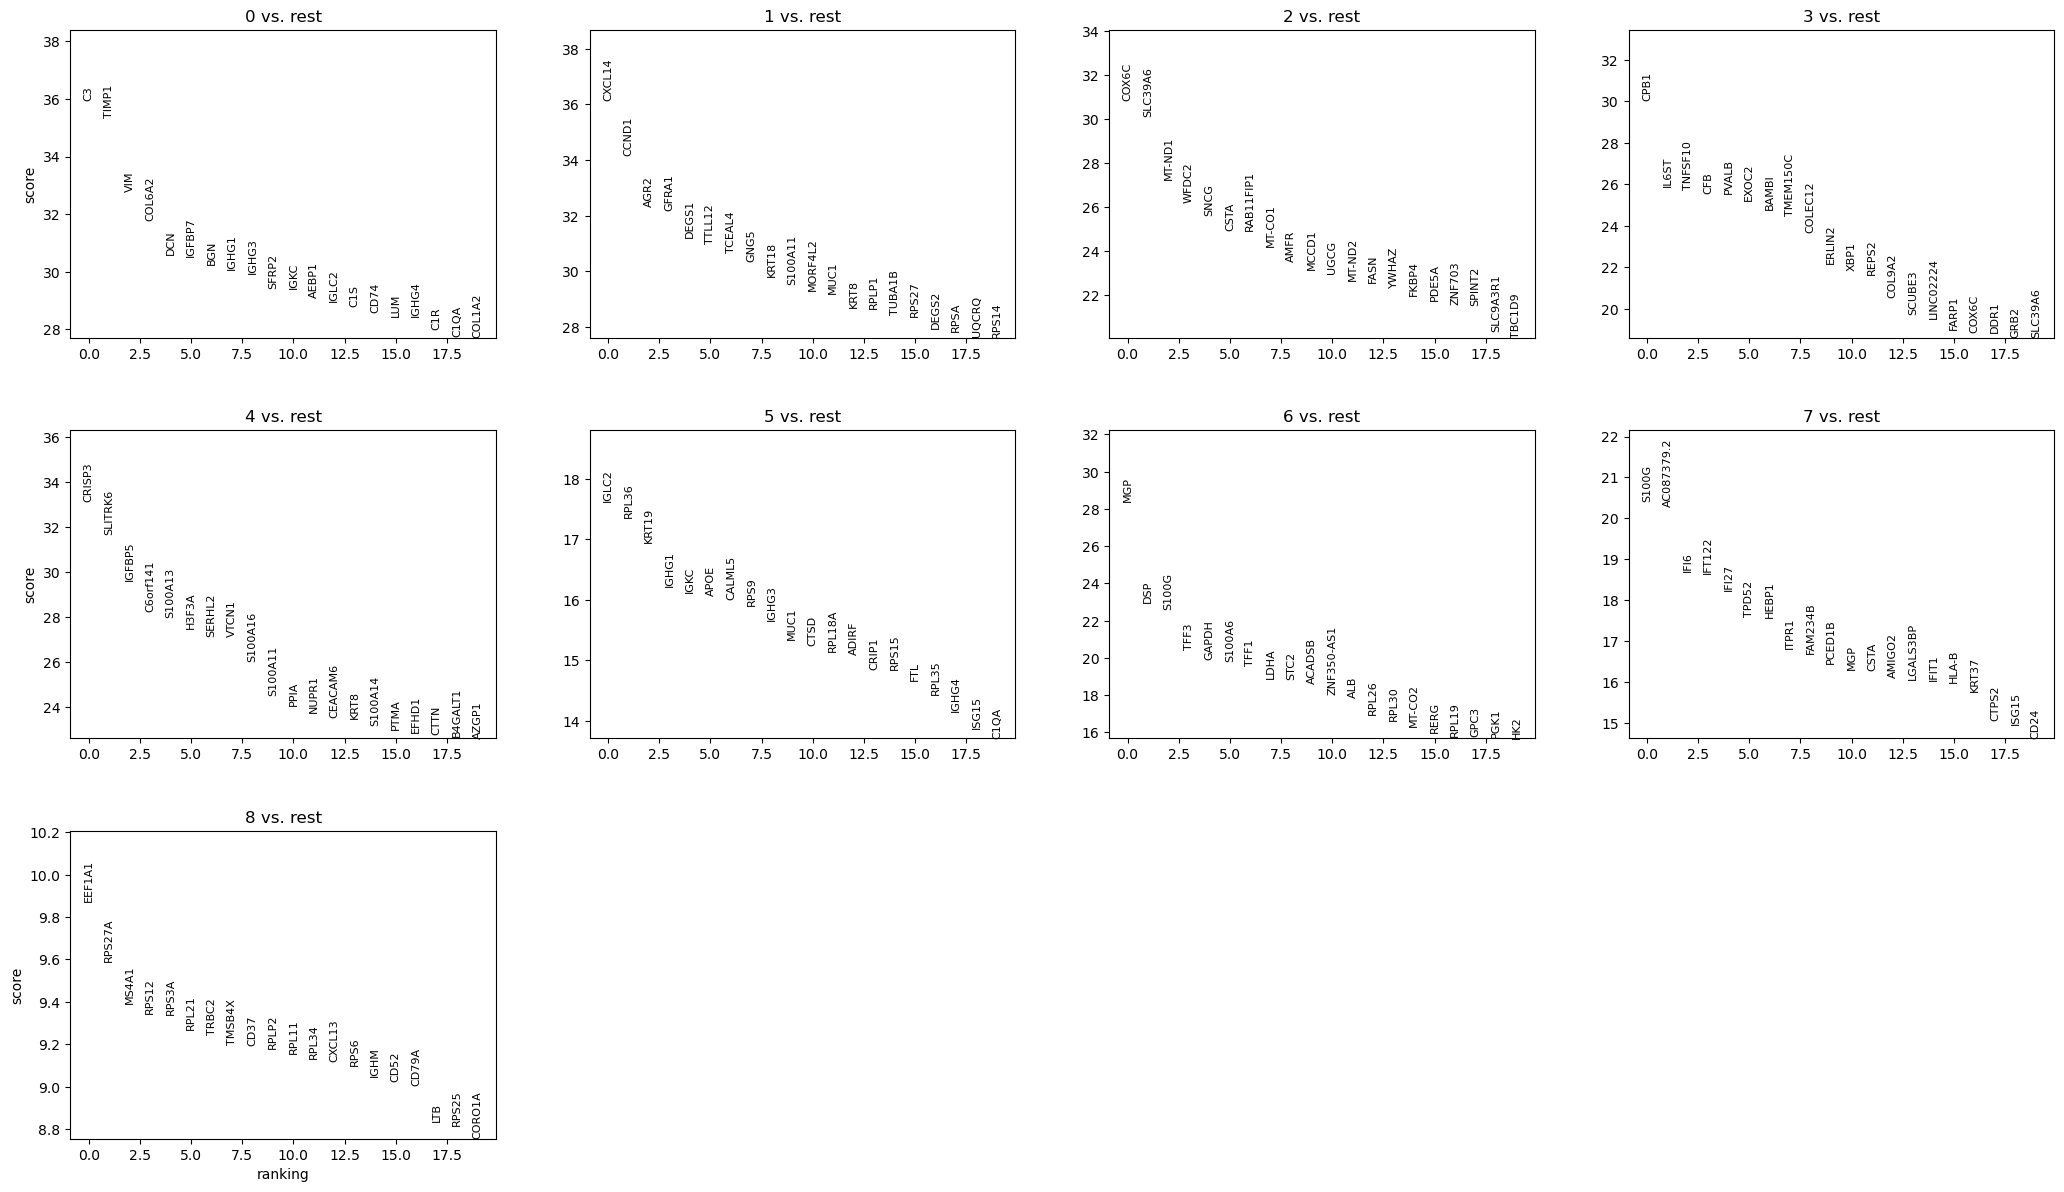

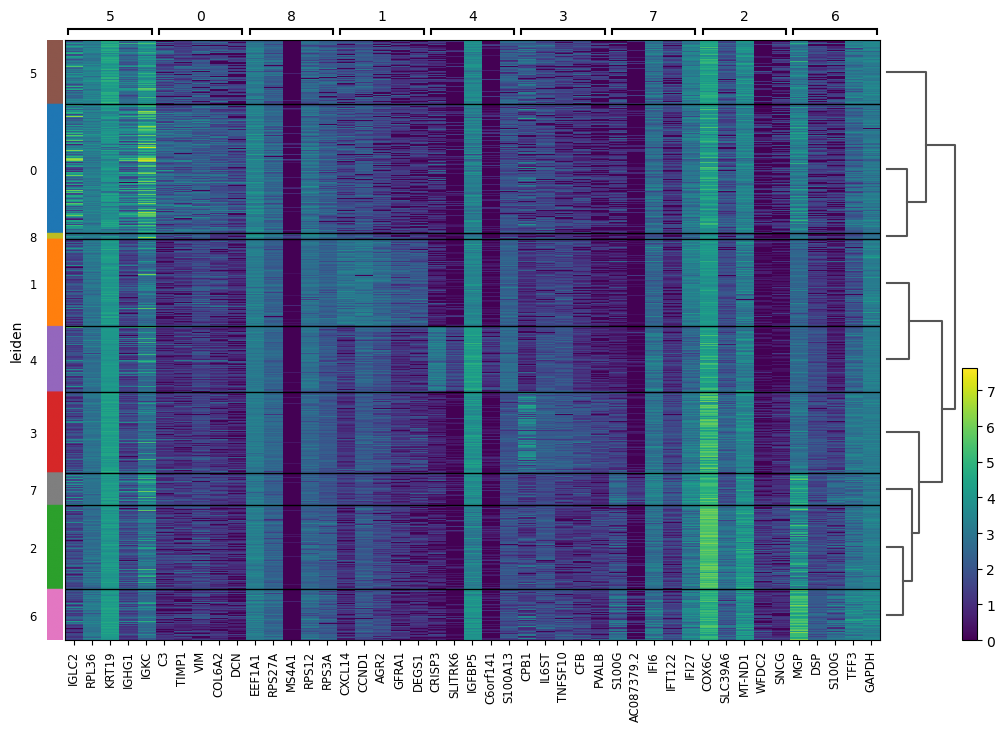


=== Top 10 Marker Genes Per Cluster ===
        0        1          2         3         4       5       6           7  \
0      C3   CXCL14      COX6C      CPB1    CRISP3   IGLC2     MGP       S100G   
1   TIMP1    CCND1    SLC39A6     IL6ST   SLITRK6   RPL36     DSP  AC087379.2   
2     VIM     AGR2     MT-ND1   TNFSF10    IGFBP5   KRT19   S100G        IFI6   
3  COL6A2    GFRA1      WFDC2       CFB  C6orf141   IGHG1    TFF3      IFT122   
4     DCN    DEGS1       SNCG     PVALB   S100A13    IGKC   GAPDH       IFI27   
5  IGFBP7   TTLL12       CSTA     EXOC2     H3F3A    APOE  S100A6       TPD52   
6     BGN   TCEAL4  RAB11FIP1     BAMBI    SERHL2  CALML5    TFF1       HEBP1   
7   IGHG1     GNG5     MT-CO1  TMEM150C     VTCN1    RPS9    LDHA       ITPR1   
8   IGHG3    KRT18       AMFR   COLEC12   S100A16   IGHG3    STC2     FAM234B   
9   SFRP2  S100A11      MCCD1    ERLIN2   S100A11    MUC1  ACADSB      PCED1B   

        8  
0  EEF1A1  
1  RPS27A  
2   MS4A1  
3   RPS12  
4   RPS

In [13]:
# Find marker genes for each cluster

print("\n=== FINDING MARKER GENES ===")

# Find differentially expressed genes for each cluster
# Uses Wilcoxon rank-sum test (non-parametric, robust)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

print("Marker gene analysis complete")

# Visualize top marker genes per cluster
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Heatmap of top 5 markers per cluster
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', 
                                 cmap='viridis', show_gene_labels=True,
                                 figsize=(12, 8))

# Get top 10 marker genes for each cluster as DataFrame
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_df = pd.DataFrame({
    group: result['names'][group][:10] for group in groups
})

print("\n=== Top 10 Marker Genes Per Cluster ===")
print(marker_df)

# Save marker genes to file
marker_df.to_csv('../results/cluster_markers.csv', index=False)
print("\nMarker genes saved to results/cluster_markers.csv")

# Visualize specific markers on UMAP (adjust gene names based on results)
# We'll add this after seeing what genes come up


=== ISOLATING CANCER CELLS FOR EVOLUTIONARY ANALYSIS ===
Cancer clusters identified: ['1', '2', '4']
  - Cluster 1: Luminal Epithelial
  - Cluster 2: Luminal Epithelial
  - Cluster 4: Basal/Myoepithelial

📊 Cancer cell subset:
   Total cancer cells: 1508
   Breakdown by cluster:
   - Cluster 1: 556 cells (36.9%)
   - Cluster 2: 535 cells (35.5%)
   - Cluster 4: 417 cells (27.7%)


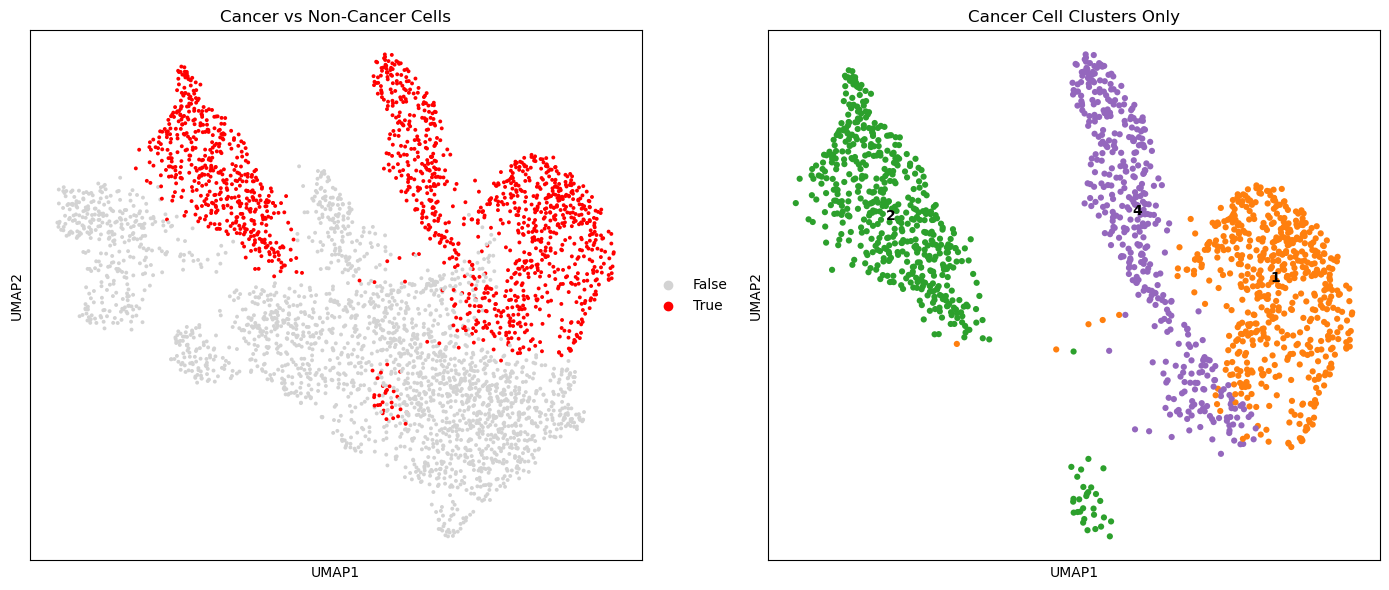


✓ Cancer cells isolated successfully
✓ Figure saved: results/cancer_cells_identification.png


In [14]:
# Isolate cancer/epithelial cells for evolutionary analysis
print("\n=== ISOLATING CANCER CELLS FOR EVOLUTIONARY ANALYSIS ===")

# Based on marker analysis, clusters 1, 2, and 4 are epithelial/cancer cells
cancer_clusters = ['1', '2', '4']

print(f"Cancer clusters identified: {cancer_clusters}")
print(f"  - Cluster 1: Luminal Epithelial")
print(f"  - Cluster 2: Luminal Epithelial") 
print(f"  - Cluster 4: Basal/Myoepithelial")

# Create a subset with only cancer cells
adata_cancer = adata[adata.obs['leiden'].isin(cancer_clusters)].copy()

print(f"\n📊 Cancer cell subset:")
print(f"   Total cancer cells: {adata_cancer.n_obs}")
print(f"   Breakdown by cluster:")
for cluster in cancer_clusters:
    count = (adata_cancer.obs['leiden'] == cluster).sum()
    pct = count / adata_cancer.n_obs * 100
    print(f"   - Cluster {cluster}: {count} cells ({pct:.1f}%)")

# Visualize cancer cells on UMAP
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Show which cells we're keeping
adata.obs['is_cancer'] = adata.obs['leiden'].isin(cancer_clusters)
sc.pl.umap(adata, color='is_cancer', ax=axes[0], show=False,
           title='Cancer vs Non-Cancer Cells', palette=['lightgray', 'red'])

# Right: Show just the cancer clusters
sc.pl.umap(adata_cancer, color='leiden', ax=axes[1], show=False,
           title='Cancer Cell Clusters Only', legend_loc='on data')

plt.tight_layout()
plt.savefig('../results/cancer_cells_identification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cancer cells isolated successfully")
print("✓ Figure saved: results/cancer_cells_identification.png")


=== VERIFYING CLUSTER LABELS ===
Cluster distribution in cancer subset:
leiden
1    556
2    535
4    417
Name: count, dtype: int64


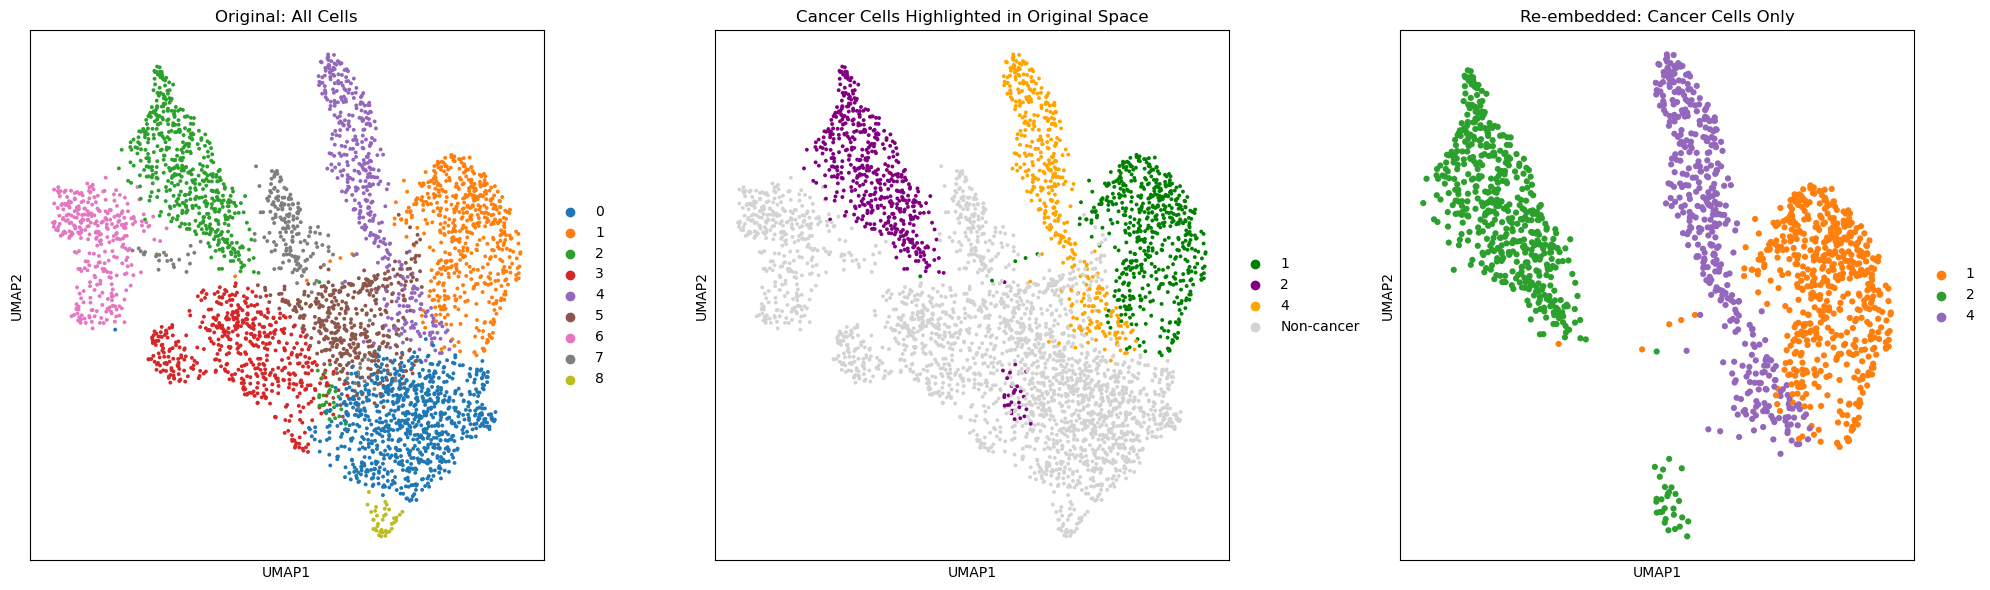


✓ The cluster labels (1, 2, 4) are preserved
✓ Only the spatial arrangement changed due to re-embedding


In [15]:
# VERIFICATION: Check that cluster labels are preserved
print("\n=== VERIFYING CLUSTER LABELS ===")

# The 'leiden' column should still have values '1', '2', '4'
print("Cluster distribution in cancer subset:")
print(adata_cancer.obs['leiden'].value_counts().sort_index())

# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Left: Original full dataset
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False,
           title='Original: All Cells', legend_loc='right margin')

# Middle: Highlight cancer cells in original UMAP
adata.obs['cell_group'] = adata.obs['leiden'].astype(str)
adata.obs.loc[~adata.obs['is_cancer'], 'cell_group'] = 'Non-cancer'
sc.pl.umap(adata, color='cell_group', ax=axes[1], show=False,
           title='Cancer Cells Highlighted in Original Space',
           palette={'1': 'green', '2': 'purple', '4': 'orange', 'Non-cancer': 'lightgray'})

# Right: New UMAP of only cancer cells
sc.pl.umap(adata_cancer, color='leiden', ax=axes[2], show=False,
           title='Re-embedded: Cancer Cells Only', legend_loc='right margin')

plt.tight_layout()
plt.savefig('../results/umap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ The cluster labels (1, 2, 4) are preserved")
print("✓ Only the spatial arrangement changed due to re-embedding")


=== IDENTIFYING CANCER SUBCLONES ===
Re-computing neighborhood graph for cancer cells...

Testing different clustering resolutions...
  Resolution 0.3: 3 subclones
  Resolution 0.5: 6 subclones
  Resolution 0.8: 7 subclones
  Resolution 1.0: 9 subclones
  Resolution 1.5: 13 subclones


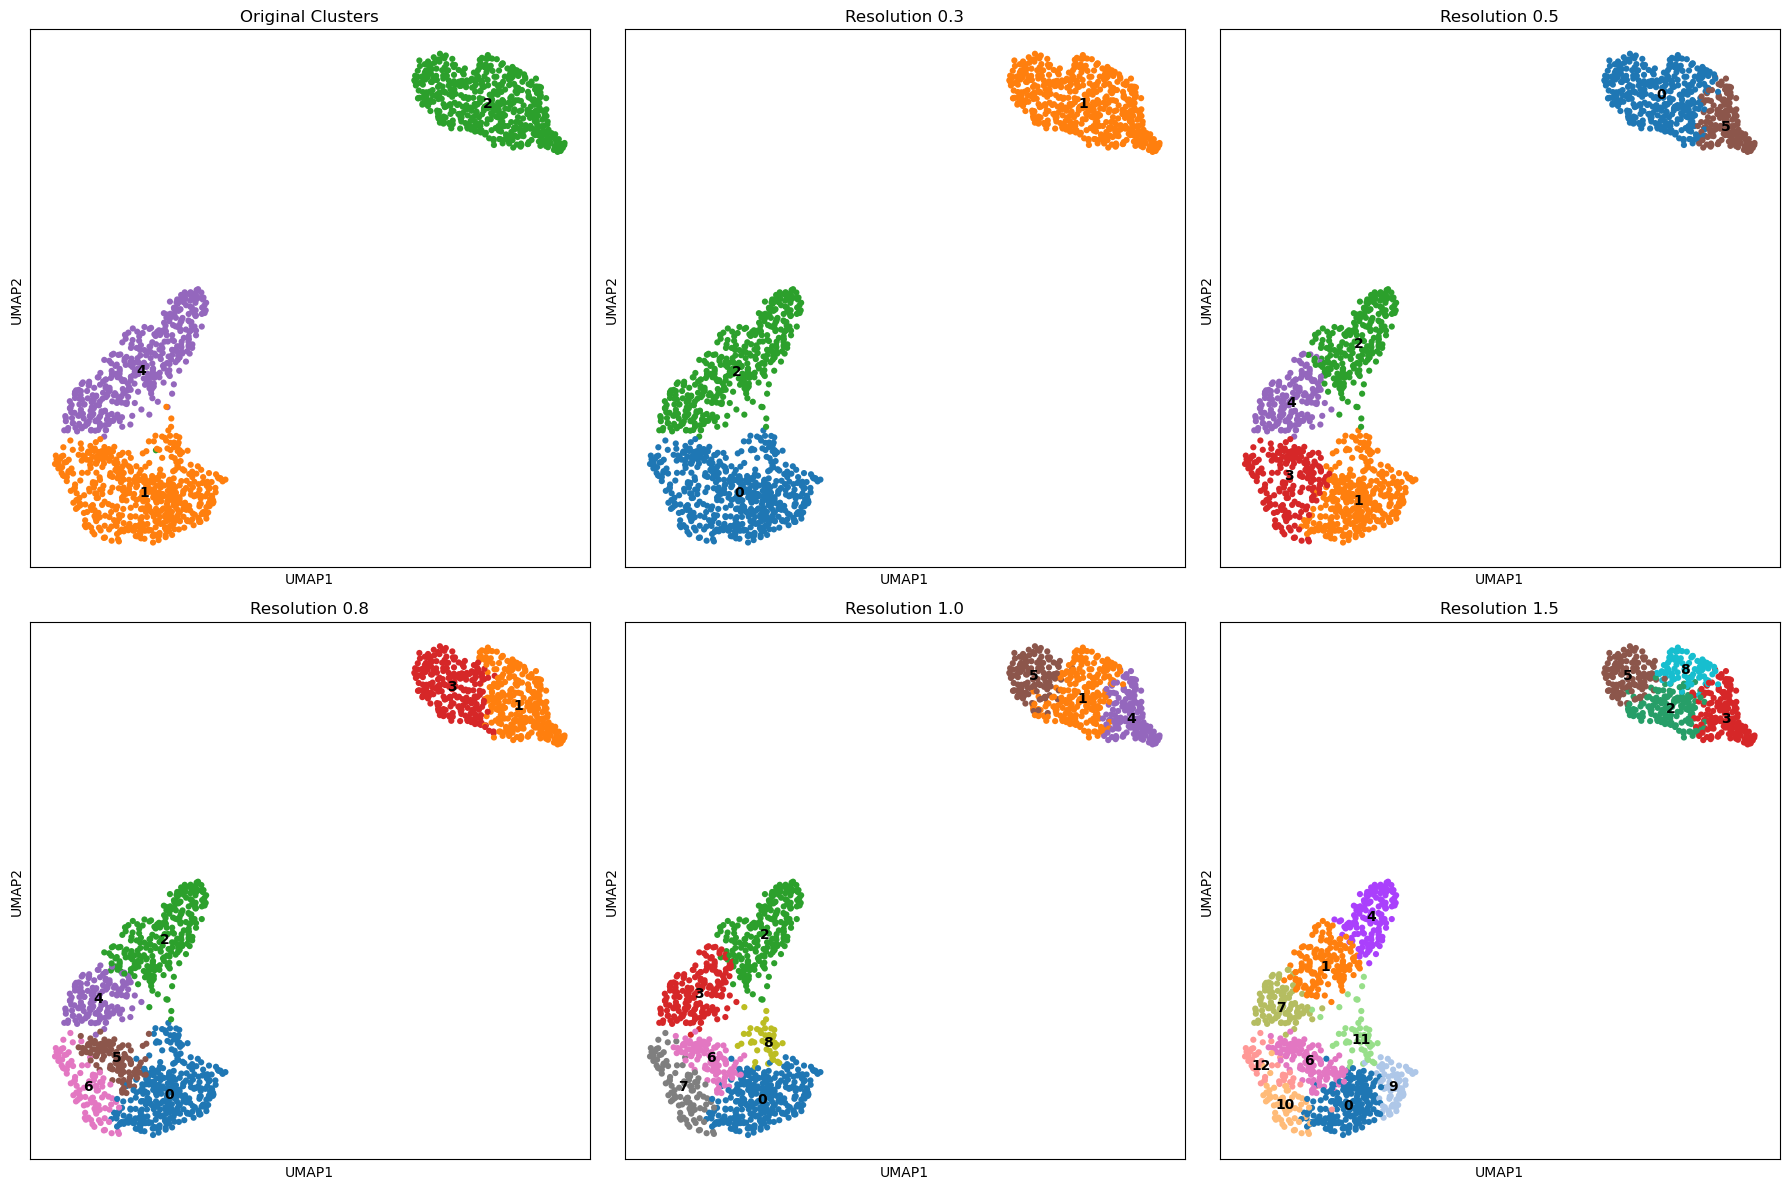


✓ Subclone identification complete
✓ Figure saved: results/subclone_resolution_test.png


In [16]:
# Re-cluster cancer cells at high resolution to find subclones
print("\n=== IDENTIFYING CANCER SUBCLONES ===")

# Re-compute neighbors and clustering on cancer cells only
# Use higher resolution to detect subtle differences (subclones)
print("Re-computing neighborhood graph for cancer cells...")
sc.pp.neighbors(adata_cancer, n_neighbors=15, n_pcs=30)

# Compute new UMAP for cancer cells
sc.tl.umap(adata_cancer)

# Cluster at multiple resolutions to find optimal subclone structure
resolutions = [0.3, 0.5, 0.8, 1.0, 1.5]
print("\nTesting different clustering resolutions...")

for res in resolutions:
    sc.tl.leiden(adata_cancer, resolution=res, key_added=f'leiden_r{res}')
    n_clusters = adata_cancer.obs[f'leiden_r{res}'].nunique()
    print(f"  Resolution {res}: {n_clusters} subclones")

# Visualize different resolutions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

sc.pl.umap(adata_cancer, color='leiden', ax=axes[0], show=False,
           title='Original Clusters', legend_loc='on data')

for idx, res in enumerate(resolutions, start=1):
    sc.pl.umap(adata_cancer, color=f'leiden_r{res}', ax=axes[idx], 
               show=False, title=f'Resolution {res}',
               legend_loc='on data')

plt.tight_layout()
plt.savefig('../results/subclone_resolution_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Subclone identification complete")
print("✓ Figure saved: results/subclone_resolution_test.png")


=== SELECTING OPTIMAL RESOLUTION FOR PHYLOGENY ===
Selected resolution: 0.8
Number of subclones: 7

📊 Subclone sizes:
   Subclone 0: 336 cells (22.3%)
   Subclone 1: 283 cells (18.8%)
   Subclone 2: 269 cells (17.8%)
   Subclone 3: 251 cells (16.6%)
   Subclone 4: 152 cells (10.1%)
   Subclone 5: 113 cells (7.5%)
   Subclone 6: 104 cells (6.9%)


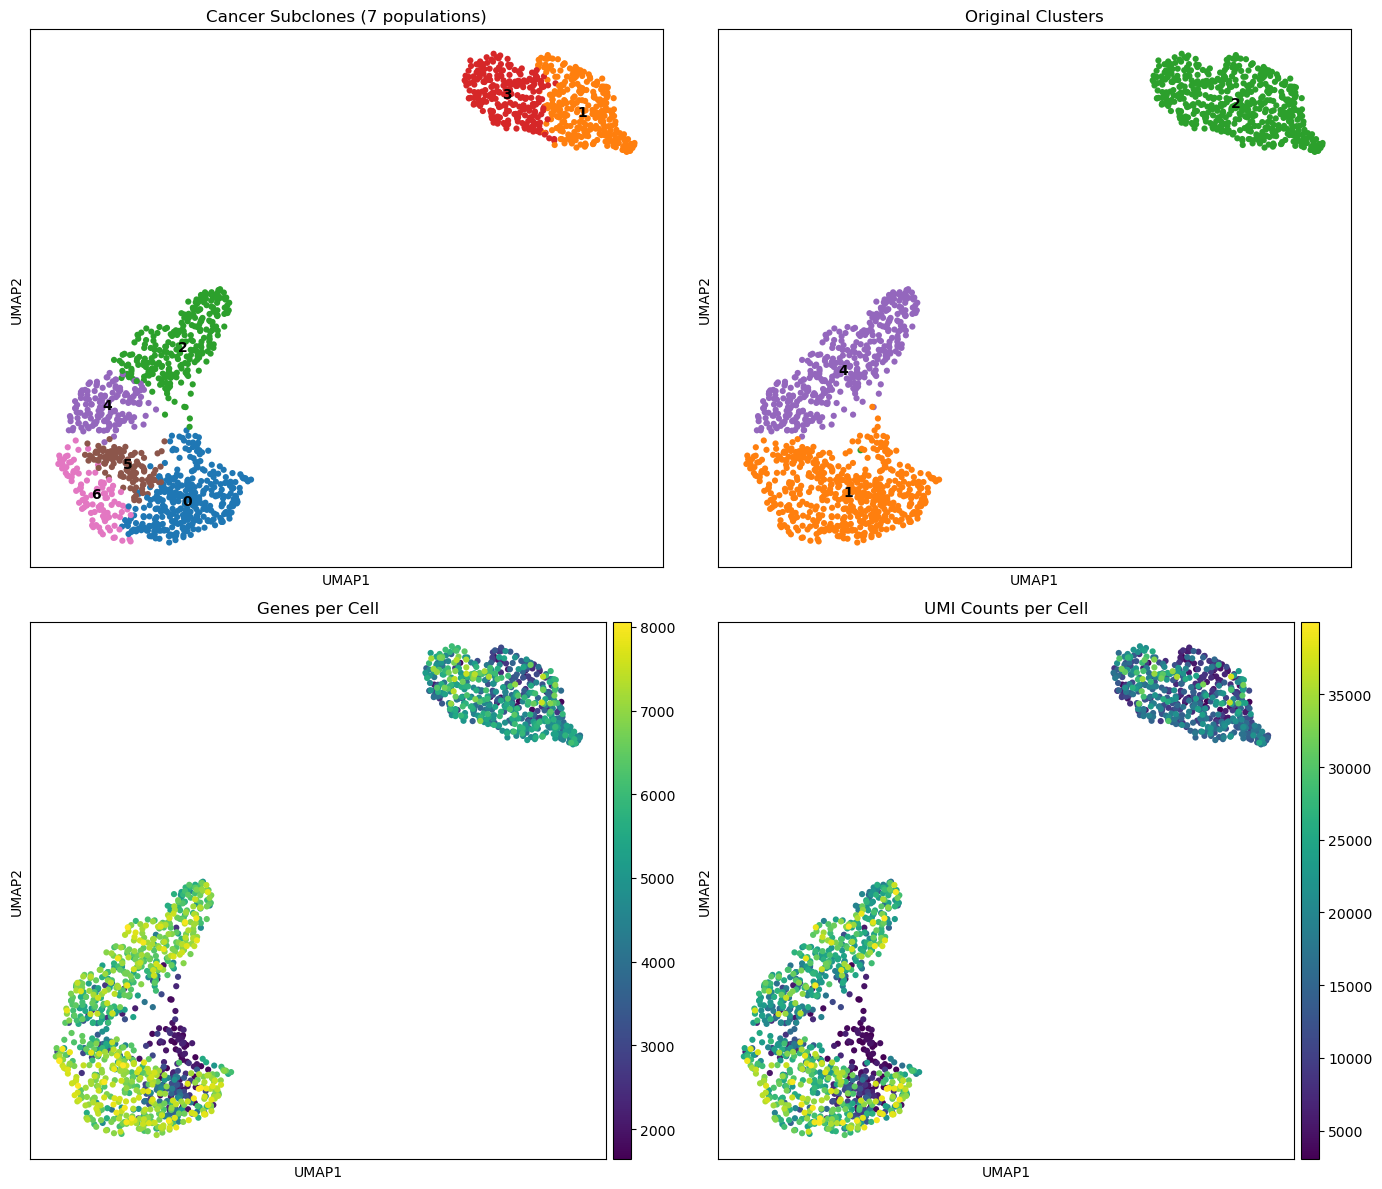


🔍 Subclone composition by original cluster:
leiden        1      2     4
subclone                    
0          99.7    0.3   0.0
1           0.0  100.0   0.0
2           1.1    0.0  98.9
3           0.0  100.0   0.0
4           0.7    0.0  99.3
5         100.0    0.0   0.0
6         100.0    0.0   0.0

✓ Subclones identified and validated
✓ Ready for phylogenetic tree construction


In [17]:
# STEP: Select optimal resolution and prepare for phylogenetic analysis
print("\n=== SELECTING OPTIMAL RESOLUTION FOR PHYLOGENY ===")

# Use resolution 0.8 (7 subclones - good balance)
optimal_resolution = 0.8
adata_cancer.obs['subclone'] = adata_cancer.obs[f'leiden_r{optimal_resolution}']

print(f"Selected resolution: {optimal_resolution}")
print(f"Number of subclones: {adata_cancer.obs['subclone'].nunique()}")

# Subclone distribution
print("\n📊 Subclone sizes:")
subclone_counts = adata_cancer.obs['subclone'].value_counts().sort_index()
for subclone, count in subclone_counts.items():
    pct = count / len(adata_cancer) * 100
    print(f"   Subclone {subclone}: {count} cells ({pct:.1f}%)")

# Visualize selected subclones with QC metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sc.pl.umap(adata_cancer, color='subclone', ax=axes[0,0], show=False,
           title='Cancer Subclones (7 populations)', legend_loc='on data')

sc.pl.umap(adata_cancer, color='leiden', ax=axes[0,1], show=False,
           title='Original Clusters', legend_loc='on data')

sc.pl.umap(adata_cancer, color='n_genes_by_counts', ax=axes[1,0], show=False,
           title='Genes per Cell', cmap='viridis')

sc.pl.umap(adata_cancer, color='total_counts', ax=axes[1,1], show=False,
           title='UMI Counts per Cell', cmap='viridis')

plt.tight_layout()
plt.savefig('../results/final_subclones_selected.png', dpi=300, bbox_inches='tight')
plt.show()

# Map subclones back to original clusters
print("\n🔍 Subclone composition by original cluster:")
subclone_composition = pd.crosstab(
    adata_cancer.obs['subclone'], 
    adata_cancer.obs['leiden'],
    normalize='index'
) * 100
print(subclone_composition.round(1))

print("\n✓ Subclones identified and validated")
print("✓ Ready for phylogenetic tree construction")


=== CONSTRUCTING PHYLOGENETIC TREE ===


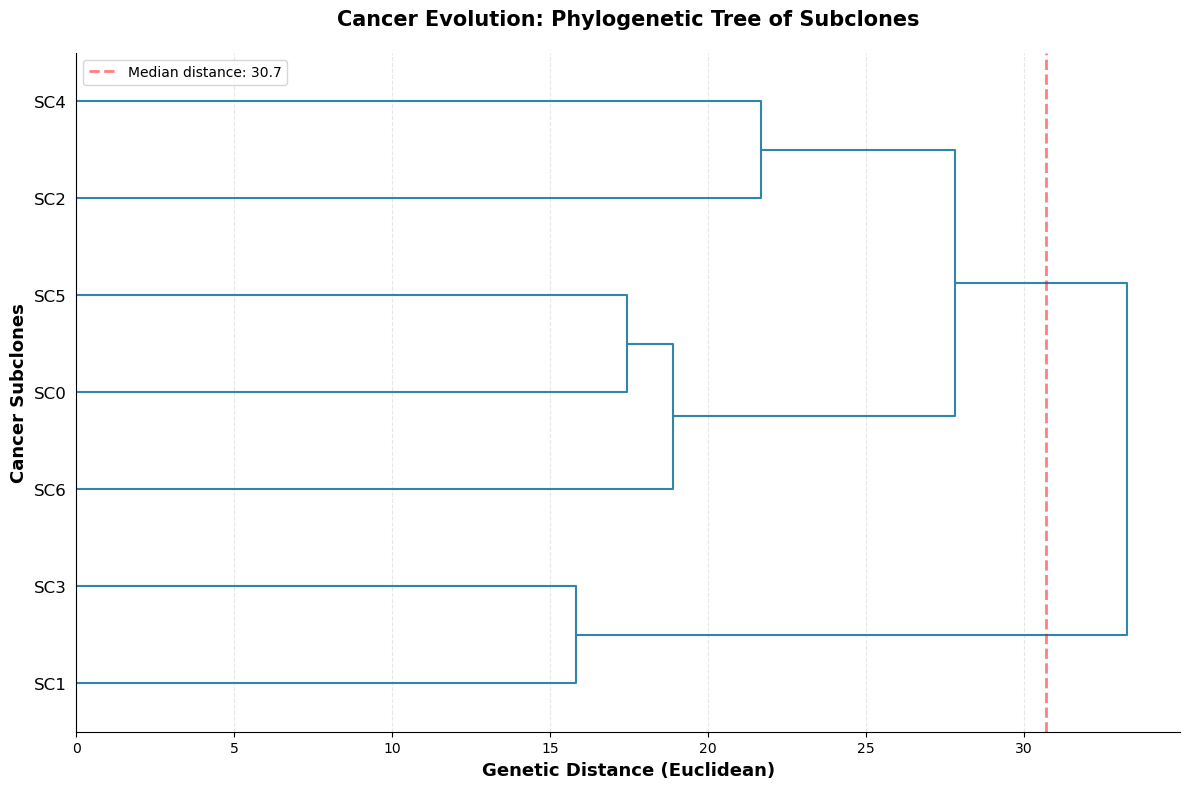

✓ Phylogenetic tree constructed
   Tree depth (max distance): 33.29
   Median pairwise distance: 30.70


In [24]:
# Import seaborn
import seaborn as sns

# Build hierarchical phylogenetic tree
print("\n=== CONSTRUCTING PHYLOGENETIC TREE ===")

# Perform hierarchical clustering (UPGMA method - commonly used for phylogenies)
linkage_matrix = linkage(distances, method='average')

# Create dendrogram (phylogenetic tree)
fig, ax = plt.subplots(figsize=(12, 8))

dendrogram_data = dendrogram(
    linkage_matrix,
    labels=subclone_labels,
    ax=ax,
    orientation='right',
    color_threshold=0,
    above_threshold_color='#2E86AB',
    leaf_font_size=12
)

# Customize appearance
ax.set_xlabel('Genetic Distance (Euclidean)', fontsize=13, fontweight='bold')
ax.set_ylabel('Cancer Subclones', fontsize=13, fontweight='bold')
ax.set_title('Cancer Evolution: Phylogenetic Tree of Subclones', 
             fontsize=15, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add vertical line at median distance for reference
median_dist = np.median(distances)
ax.axvline(x=median_dist, color='red', linestyle='--', 
           alpha=0.5, linewidth=2, label=f'Median distance: {median_dist:.1f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('../results/phylogenetic_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Phylogenetic tree constructed")
print(f"   Tree depth (max distance): {linkage_matrix[:, 2].max():.2f}")
print(f"   Median pairwise distance: {median_dist:.2f}")


=== CALCULATING GENETIC DISTANCES BETWEEN SUBCLONES ===
Subclone expression matrix: (7, 20814)
  7 subclones × 20814 genes

Calculating pairwise genetic distances...

📐 Pairwise Genetic Distances:
       SC0    SC1    SC2    SC3    SC4    SC5    SC6
SC0   0.00  32.87  28.99  30.70  25.27  17.43  19.74
SC1  32.87   0.00  33.43  15.83  33.06  36.46  40.03
SC2  28.99  33.43   0.00  31.86  21.67  30.78  31.83
SC3  30.70  15.83  31.86   0.00  27.69  31.40  35.36
SC4  25.27  33.06  21.67  27.69   0.00  23.97  26.18
SC5  17.43  36.46  30.78  31.40  23.97   0.00  18.07
SC6  19.74  40.03  31.83  35.36  26.18  18.07   0.00


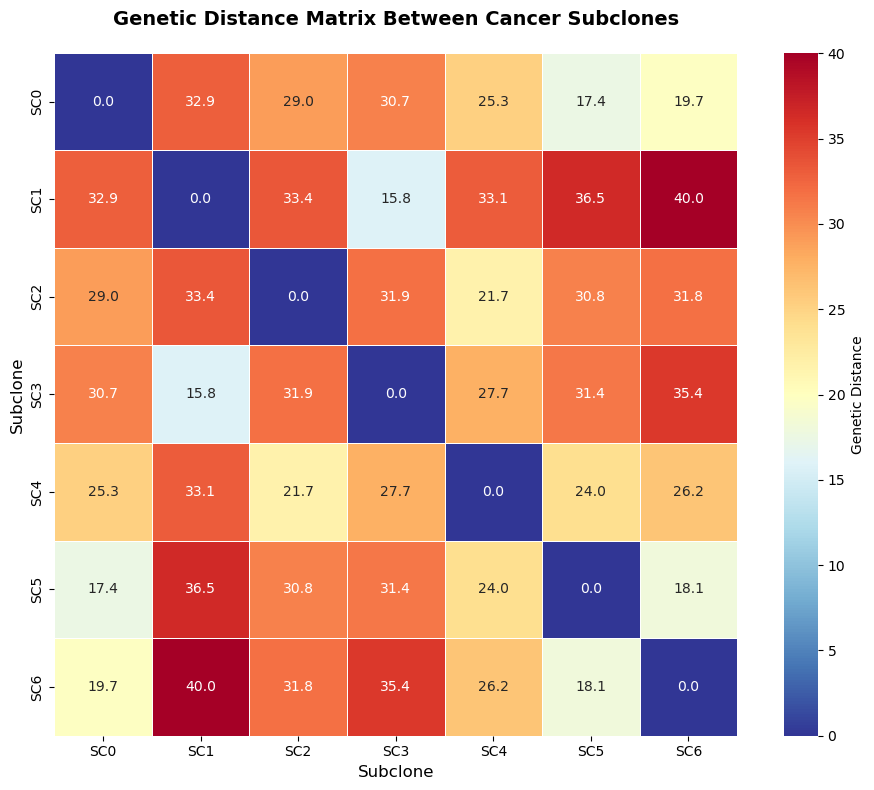


✓ Genetic distances calculated
✓ Distance matrix saved


In [25]:
# Import seaborn
import seaborn as sns
# Calculate genetic distances between subclones
print("\n=== CALCULATING GENETIC DISTANCES BETWEEN SUBCLONES ===")

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate mean expression profile for each subclone
subclone_profiles = []
subclone_labels = []

for subclone in sorted(adata_cancer.obs['subclone'].unique()):
    # Get cells in this subclone
    mask = adata_cancer.obs['subclone'] == subclone
    
    # Calculate mean expression across all genes
    if hasattr(adata_cancer.X, 'toarray'):
        profile = adata_cancer.X[mask, :].toarray().mean(axis=0)
    else:
        profile = adata_cancer.X[mask, :].mean(axis=0)
    
    subclone_profiles.append(profile.flatten())
    subclone_labels.append(f"SC{subclone}")

# Create expression matrix
subclone_matrix = np.array(subclone_profiles)
print(f"Subclone expression matrix: {subclone_matrix.shape}")
print(f"  {len(subclone_labels)} subclones × {subclone_matrix.shape[1]} genes")

# Calculate pairwise Euclidean distances
print("\nCalculating pairwise genetic distances...")
distances = pdist(subclone_matrix, metric='euclidean')
distance_matrix = squareform(distances)

# Create distance dataframe
distance_df = pd.DataFrame(
    distance_matrix,
    index=subclone_labels,
    columns=subclone_labels
)

print("\n📐 Pairwise Genetic Distances:")
print(distance_df.round(2))

# Visualize distance matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, annot=True, cmap='RdYlBu_r', 
            square=True, fmt='.1f', 
            cbar_kws={'label': 'Genetic Distance'},
            linewidths=0.5)
plt.title('Genetic Distance Matrix Between Cancer Subclones', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Subclone', fontsize=12)
plt.ylabel('Subclone', fontsize=12)
plt.tight_layout()
plt.savefig('../results/genetic_distance_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Genetic distances calculated")
print("✓ Distance matrix saved")


=== CREATING EVOLUTIONARY MAP ===


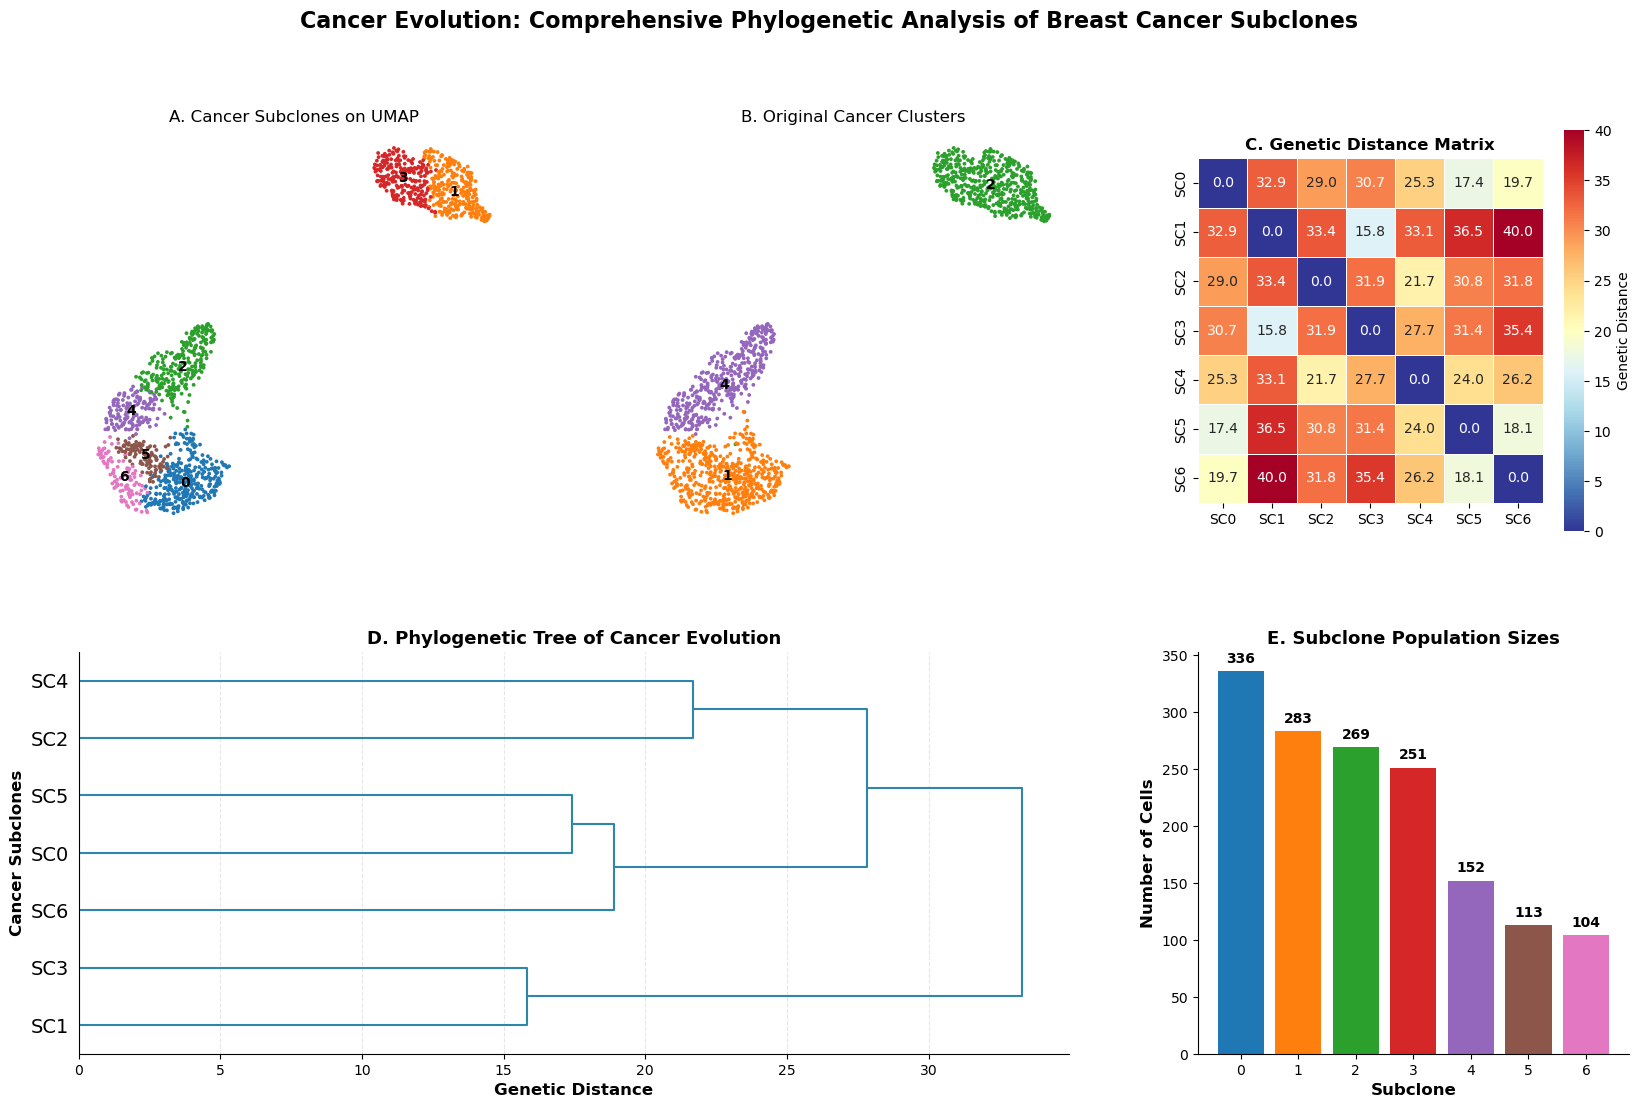

✓ Comprehensive evolutionary map created
✓ Saved: results/comprehensive_evolutionary_map.png


In [27]:
# Create comprehensive evolutionary map
print("\n=== CREATING EVOLUTIONARY MAP ===")

# Create a large multi-panel figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Panel A: UMAP with subclones
ax1 = fig.add_subplot(gs[0, 0])
sc.pl.umap(adata_cancer, color='subclone', ax=ax1, show=False,
           title='A. Cancer Subclones on UMAP', legend_loc='on data',
           frameon=False, size=30)

# Panel B: UMAP with original clusters
ax2 = fig.add_subplot(gs[0, 1])
sc.pl.umap(adata_cancer, color='leiden', ax=ax2, show=False,
           title='B. Original Cancer Clusters', legend_loc='on data',
           frameon=False, size=30)

# Panel C: Distance heatmap
ax3 = fig.add_subplot(gs[0, 2])
sns.heatmap(distance_df, annot=True, cmap='RdYlBu_r', 
            square=True, fmt='.1f', ax=ax3,
            cbar_kws={'label': 'Genetic Distance'},
            linewidths=0.5)
ax3.set_title('C. Genetic Distance Matrix', fontsize=12, fontweight='bold')

# Panel D: Phylogenetic tree (larger, spans 2 columns)
ax4 = fig.add_subplot(gs[1, :2])
dendrogram_data = dendrogram(
    linkage_matrix,
    labels=subclone_labels,
    ax=ax4,
    orientation='right',
    color_threshold=0,
    above_threshold_color='#2E86AB',
    leaf_font_size=14
)
ax4.set_xlabel('Genetic Distance', fontsize=12, fontweight='bold')
ax4.set_ylabel('Cancer Subclones', fontsize=12, fontweight='bold')
ax4.set_title('D. Phylogenetic Tree of Cancer Evolution', 
              fontsize=13, fontweight='bold')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.grid(axis='x', alpha=0.3, linestyle='--')

# Panel E: Subclone size distribution
ax5 = fig.add_subplot(gs[1, 2])
subclone_sizes = adata_cancer.obs['subclone'].value_counts().sort_index()
colors_map = {
    '0': '#1f77b4', '1': '#ff7f0e', '2': '#2ca02c', '3': '#d62728',
    '4': '#9467bd', '5': '#8c564b', '6': '#e377c2'
}
colors = [colors_map[str(i)] for i in subclone_sizes.index]
ax5.bar(subclone_sizes.index.astype(str), subclone_sizes.values, color=colors)
ax5.set_xlabel('Subclone', fontsize=12, fontweight='bold')
ax5.set_ylabel('Number of Cells', fontsize=12, fontweight='bold')
ax5.set_title('E. Subclone Population Sizes', fontsize=13, fontweight='bold')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
for i, (idx, val) in enumerate(subclone_sizes.items()):
    ax5.text(i, val + 5, str(val), ha='center', va='bottom', fontweight='bold')

# Add main title
fig.suptitle('Cancer Evolution: Comprehensive Phylogenetic Analysis of Breast Cancer Subclones',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('../results/comprehensive_evolutionary_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive evolutionary map created")
print("✓ Saved: results/comprehensive_evolutionary_map.png")


=== CREATING UMAP WITH EVOLUTIONARY CONNECTIONS ===


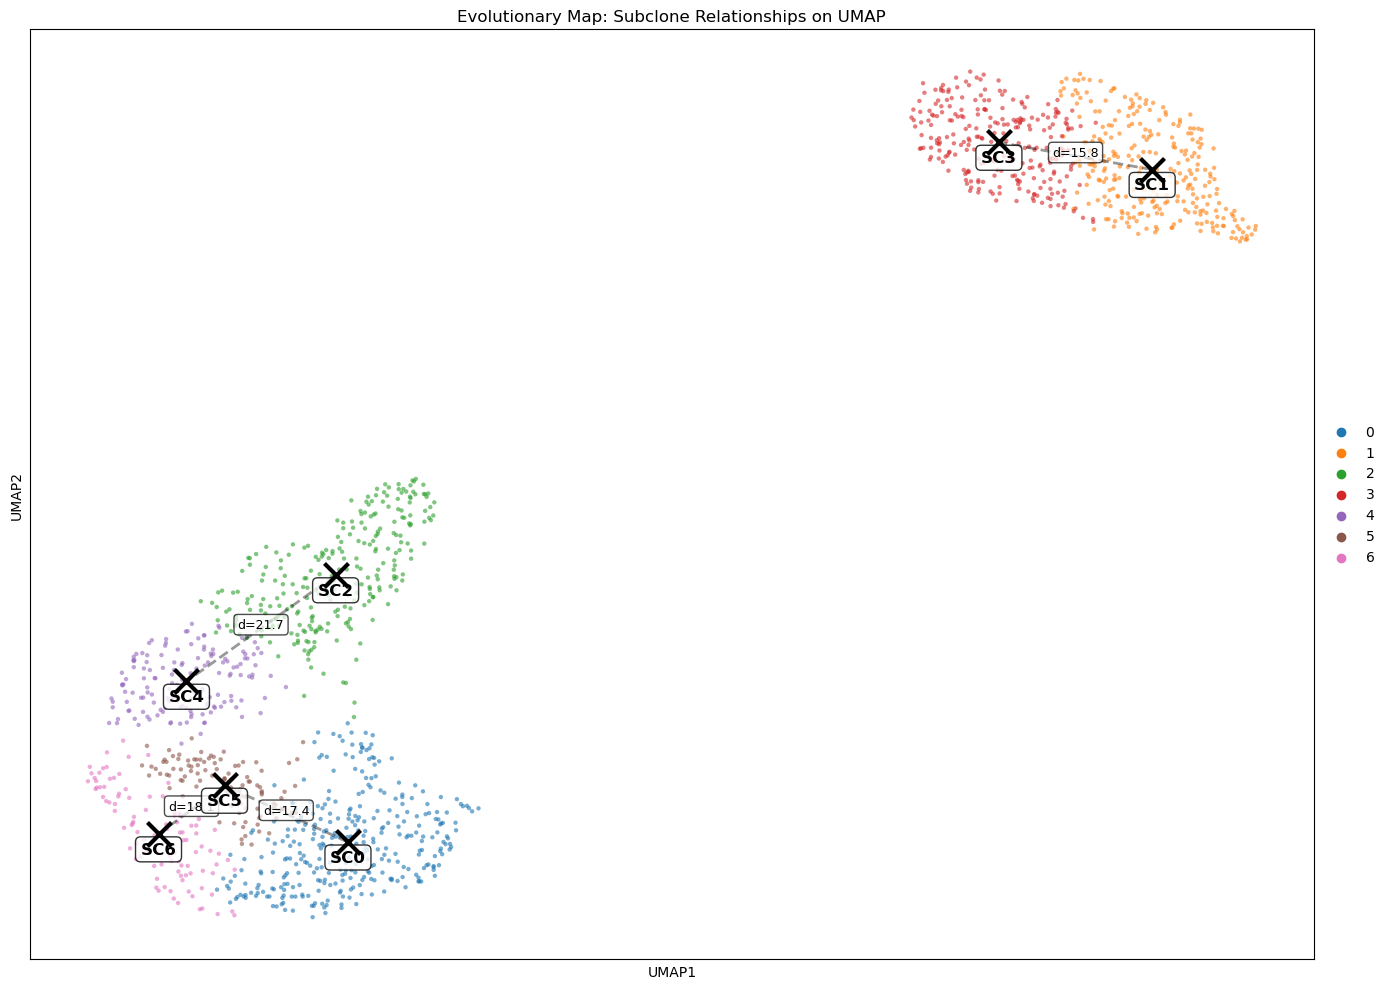

✓ Evolutionary map with connections created
✓ Saved: results/evolutionary_map_with_connections.png


In [28]:
# Create UMAP with phylogenetic connections
print("\n=== CREATING UMAP WITH EVOLUTIONARY CONNECTIONS ===")

# Calculate subclone centroids in UMAP space
centroids = {}
for subclone in sorted(adata_cancer.obs['subclone'].unique()):
    mask = adata_cancer.obs['subclone'] == subclone
    umap_coords = adata_cancer.obsm['X_umap'][mask]
    centroids[subclone] = umap_coords.mean(axis=0)

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot UMAP
sc.pl.umap(adata_cancer, color='subclone', ax=ax, show=False,
           legend_loc='right margin', size=40, alpha=0.6,
           title='Evolutionary Map: Subclone Relationships on UMAP')

# Draw connections between closely related subclones
# Based on phylogenetic tree structure
close_pairs = [
    ('1', '3', 15.8),  # Closest pair
    ('0', '5', 17.4),
    ('5', '6', 18.1),
    ('2', '4', 21.7),
]

for sc1, sc2, dist in close_pairs:
    if sc1 in centroids and sc2 in centroids:
        x1, y1 = centroids[sc1]
        x2, y2 = centroids[sc2]
        ax.plot([x1, x2], [y1, y2], 'k--', alpha=0.4, linewidth=2)
        # Add distance label
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        ax.text(mid_x, mid_y, f'd={dist:.1f}', 
                fontsize=9, ha='center', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Label centroids
for subclone, (x, y) in centroids.items():
    ax.scatter(x, y, s=300, c='black', marker='x', linewidths=3, zorder=100)
    ax.text(x, y-0.5, f'SC{subclone}', fontsize=12, ha='center', 
            fontweight='bold', color='black',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../results/evolutionary_map_with_connections.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Evolutionary map with connections created")
print("✓ Saved: results/evolutionary_map_with_connections.png")


ANALYSIS 1: IDENTIFYING SUBCLONE-SPECIFIC DRIVER GENES

📊 Top 10 Driver Genes Per Subclone:

Subclone 0 (n=336 cells)
 names    scores  logfoldchanges     pvals_adj
CXCL14 23.575678        2.572648 1.425242e-118
TTLL12 20.458794        1.969478  5.220501e-89
 CCND1 20.160585        1.059599  1.507615e-86
  AGR2 20.141472        1.208874  1.663532e-86
 GFRA1 20.123779        1.503014  1.901921e-86
 RPS14 19.815907        0.526937  7.529917e-84
  GNG5 19.427105        1.089900  1.250359e-80
  MUC1 19.424334        0.833622  1.250359e-80
 RPS27 18.854914        0.466546  6.192658e-76
 DEGS1 18.836370        1.566168  7.912723e-76

Subclone 1 (n=283 cells)
    names    scores  logfoldchanges     pvals_adj
    COX6C 22.741255        1.674450 3.645595e-110
     CSTA 22.624483        2.284445 2.589959e-109
  SLC39A6 21.477360        1.453156  1.758891e-98
    BAMBI 20.825191        1.213110  1.331562e-92
   MT-ND1 20.366888        1.307456  1.141045e-88
RAB11FIP1 20.323118        1.492400  2

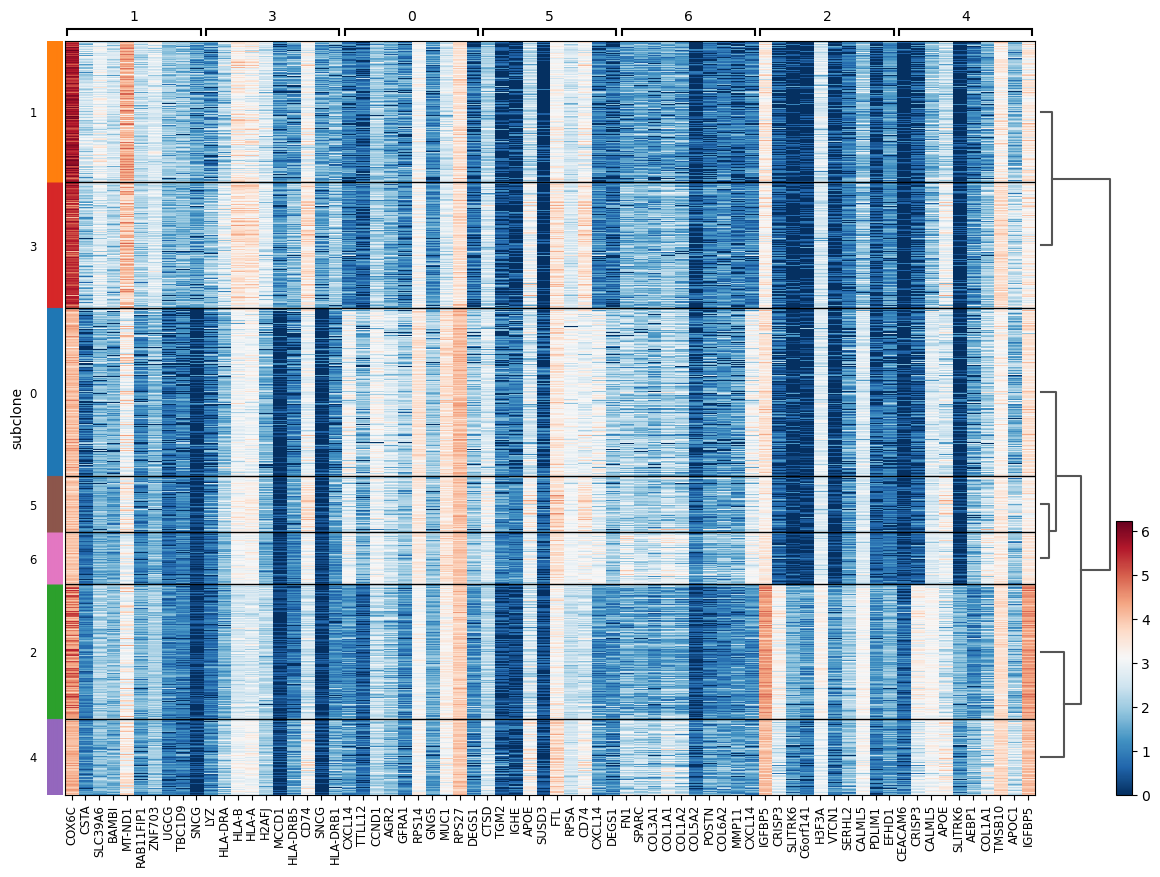

<Figure size 640x480 with 0 Axes>

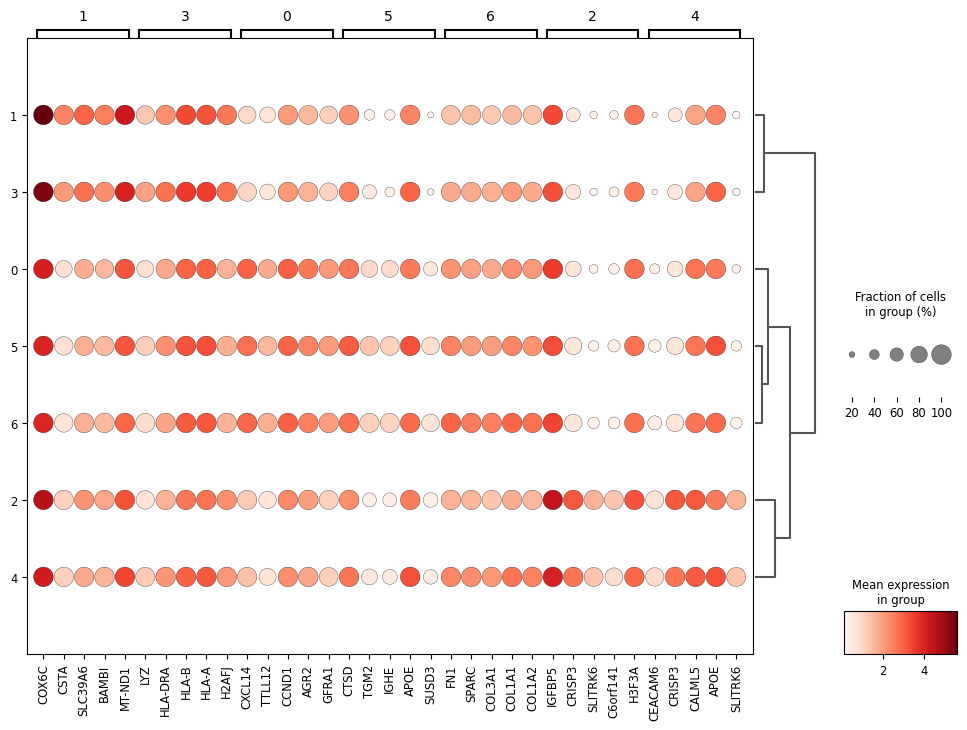

<Figure size 640x480 with 0 Axes>

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


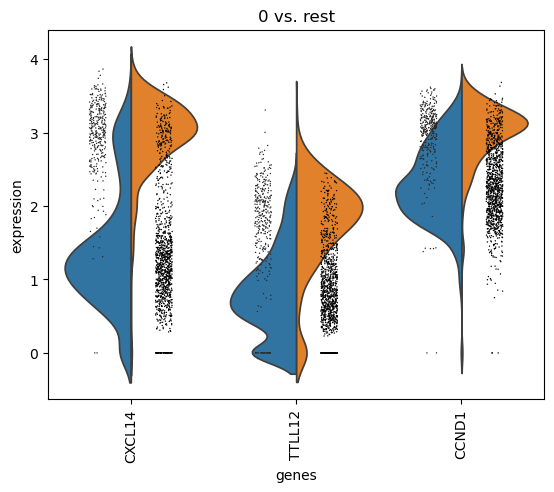

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


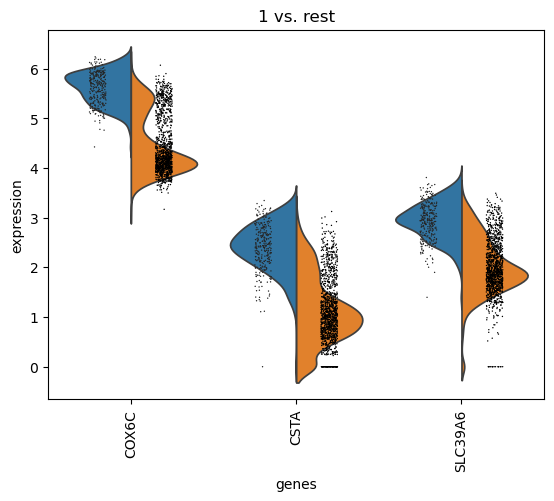

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


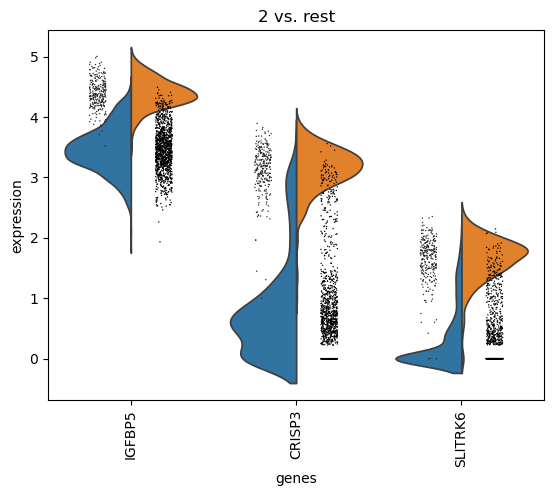

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


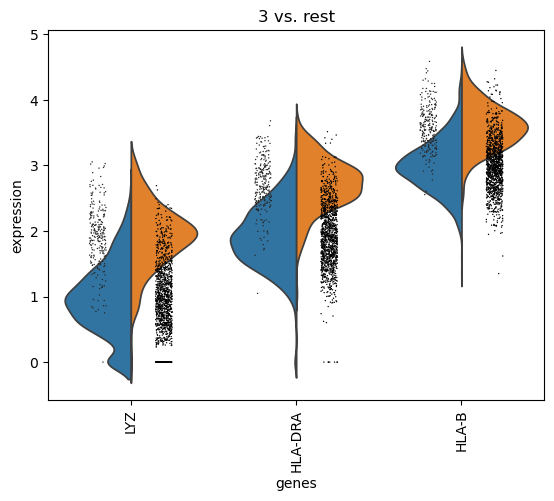

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


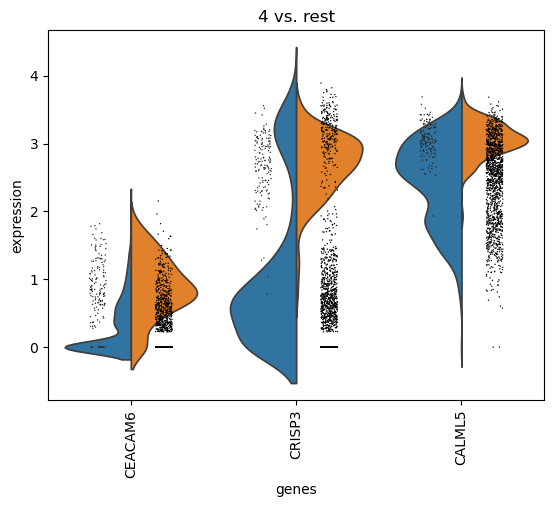

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


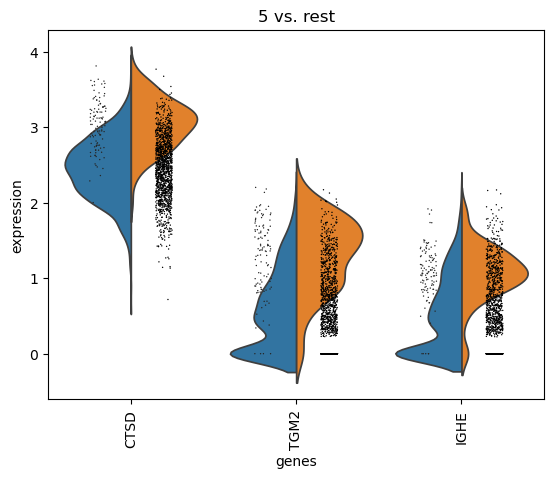

c:\Users\manju\miniconda3\envs\cancer-sc\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


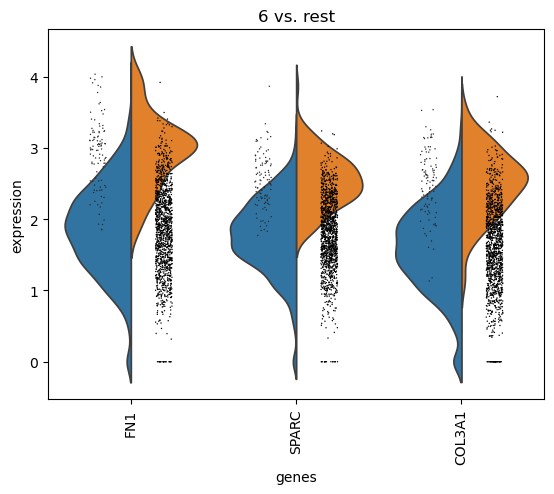

<Figure size 640x480 with 0 Axes>


✓ Driver genes identified and saved
✓ Files: ../results/driver_genes_subclone_*.csv


In [29]:
print("\n" + "="*80)
print("ANALYSIS 1: IDENTIFYING SUBCLONE-SPECIFIC DRIVER GENES")
print("="*80)

# Find marker genes for each subclone
sc.tl.rank_genes_groups(adata_cancer, 'subclone', method='wilcoxon')

# Get top markers per subclone
print("\n📊 Top 10 Driver Genes Per Subclone:")
all_markers = []

for subclone in sorted(adata_cancer.obs['subclone'].unique()):
    markers = sc.get.rank_genes_groups_df(adata_cancer, group=subclone)
    n_cells = sum(adata_cancer.obs['subclone']==subclone)
    
    print(f"\n{'='*70}")
    print(f"Subclone {subclone} (n={n_cells} cells)")
    print(f"{'='*70}")
    top_genes = markers.head(10)
    print(top_genes[['names', 'scores', 'logfoldchanges', 'pvals_adj']].to_string(index=False))
    
    # Save all markers
    markers.to_csv(f'../results/driver_genes_subclone_{subclone}.csv', index=False)
    all_markers.append(markers.head(10))

# Visualize top markers - Heatmap
print("\n📈 Creating marker gene visualizations...")
sc.pl.rank_genes_groups_heatmap(adata_cancer, n_genes=10, groupby='subclone',
                                 cmap='RdBu_r', figsize=(14, 10),
                                 show_gene_labels=True, dendrogram=True)
plt.savefig('../results/subclone_driver_genes_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Create dot plot
sc.pl.rank_genes_groups_dotplot(adata_cancer, n_genes=5, groupby='subclone',
                                 figsize=(12, 8), dendrogram=True)
plt.savefig('../results/subclone_markers_dotplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Violin plots for top markers (FIXED - no groupby parameter)
sc.pl.rank_genes_groups_violin(adata_cancer, n_genes=3)
plt.savefig('../results/subclone_markers_violin.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Driver genes identified and saved")
print("✓ Files: ../results/driver_genes_subclone_*.csv")


ANALYSIS 2: TRAJECTORY ANALYSIS - EVOLUTIONARY PSEUDOTIME

🔬 Computing PAGA trajectory...
Creating PAGA graph...


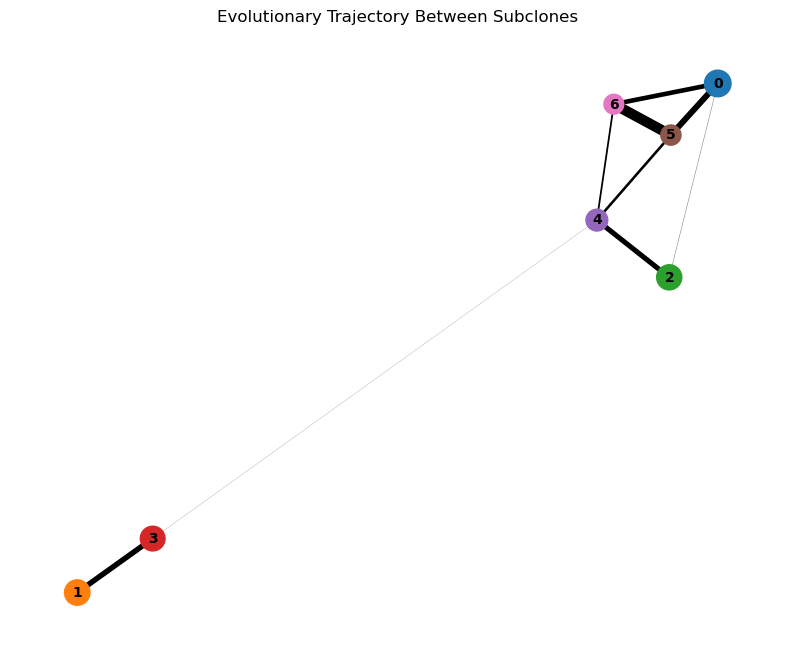

Overlaying trajectory on UMAP...


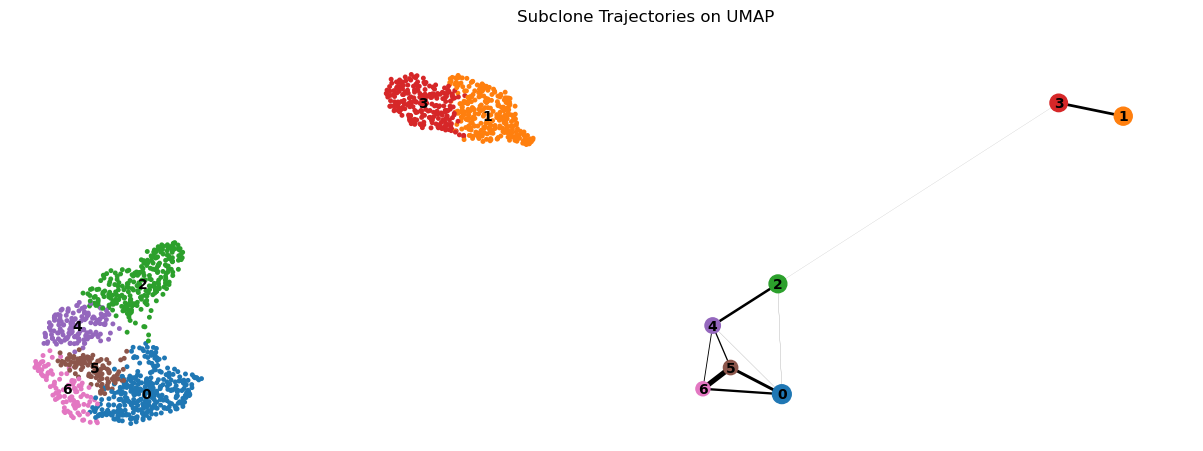

<Figure size 640x480 with 0 Axes>


⏱️ Computing diffusion pseudotime...
Root subclone: 0
Pseudotime range: 0.000 to 1.000


C:\Users\manju\AppData\Local\Temp\ipykernel_29076\3081832143.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pseudotime_df, x='subclone', y='dpt_pseudotime',


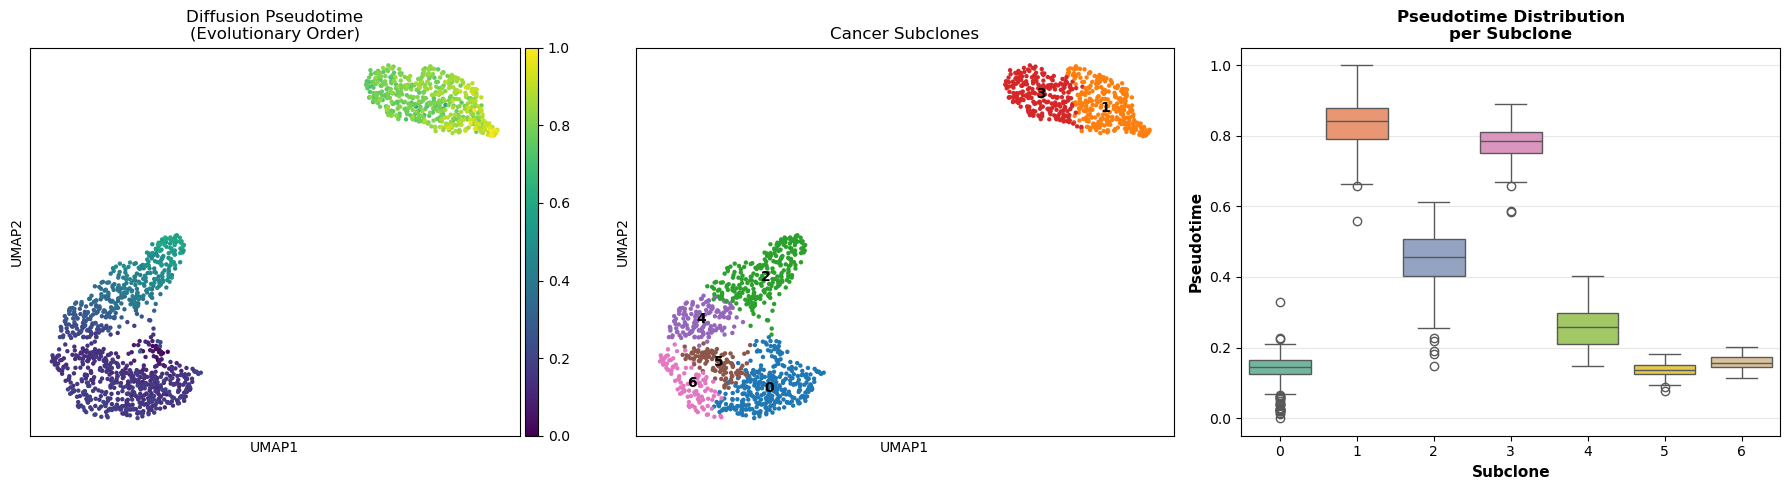


✓ Trajectory analysis complete
✓ Files saved:
  - paga_trajectory.png
  - trajectory_on_umap.png
  - pseudotime_analysis.png


In [30]:
print("\n" + "="*80)
print("ANALYSIS 2: TRAJECTORY ANALYSIS - EVOLUTIONARY PSEUDOTIME")
print("="*80)

# Run PAGA (Partition-based graph abstraction)
print("\n🔬 Computing PAGA trajectory...")
sc.tl.paga(adata_cancer, groups='subclone')

# Plot PAGA trajectory
print("Creating PAGA graph...")
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.paga(adata_cancer, color='subclone', 
           title='Evolutionary Trajectory Between Subclones',
           frameon=False, node_size_scale=2,
           ax=ax, show=False)
plt.savefig('../results/paga_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

# Overlay PAGA on UMAP
print("Overlaying trajectory on UMAP...")
sc.pl.paga_compare(adata_cancer, basis='umap', 
                   title='Subclone Trajectories on UMAP',
                   frameon=False, size=50, legend_loc='on data',
                   edge_width_scale=0.5)
plt.savefig('../results/trajectory_on_umap.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute diffusion pseudotime (evolutionary ordering)
print("\n⏱️ Computing diffusion pseudotime...")
# Set root as subclone 0 (you can change this based on biological knowledge)
adata_cancer.uns['iroot'] = np.flatnonzero(adata_cancer.obs['subclone'] == '0')[0]
sc.tl.dpt(adata_cancer)

print(f"Root subclone: 0")
print(f"Pseudotime range: {adata_cancer.obs['dpt_pseudotime'].min():.3f} to {adata_cancer.obs['dpt_pseudotime'].max():.3f}")

# Visualize pseudotime
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata_cancer, color='dpt_pseudotime', ax=axes[0], show=False,
           title='Diffusion Pseudotime\n(Evolutionary Order)', 
           cmap='viridis', size=40, colorbar_loc='right')

sc.pl.umap(adata_cancer, color='subclone', ax=axes[1], show=False,
           title='Cancer Subclones', legend_loc='on data', size=40)

# Plot pseudotime distribution per subclone
import seaborn as sns
pseudotime_df = adata_cancer.obs[['subclone', 'dpt_pseudotime']].copy()
sns.boxplot(data=pseudotime_df, x='subclone', y='dpt_pseudotime', 
            ax=axes[2], palette='Set2')
axes[2].set_xlabel('Subclone', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Pseudotime', fontsize=11, fontweight='bold')
axes[2].set_title('Pseudotime Distribution\nper Subclone', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/pseudotime_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Trajectory analysis complete")
print("✓ Files saved:")
print("  - paga_trajectory.png")
print("  - trajectory_on_umap.png")
print("  - pseudotime_analysis.png")


ANALYSIS 3: FUNCTIONAL PATHWAY ENRICHMENT ANALYSIS

🧬 Extracting top marker genes for pathway enrichment...
Subclone 0: 100 significant marker genes
  Top 5: CXCL14, TTLL12, CCND1, AGR2, GFRA1
Subclone 1: 100 significant marker genes
  Top 5: COX6C, CSTA, SLC39A6, BAMBI, MT-ND1
Subclone 2: 100 significant marker genes
  Top 5: IGFBP5, CRISP3, SLITRK6, C6orf141, H3F3A
Subclone 3: 100 significant marker genes
  Top 5: LYZ, HLA-DRA, HLA-B, HLA-A, H2AFJ
Subclone 4: 100 significant marker genes
  Top 5: CEACAM6, CRISP3, CALML5, APOE, SLITRK6
Subclone 5: 100 significant marker genes
  Top 5: CTSD, TGM2, IGHE, APOE, SUSD3
Subclone 6: 100 significant marker genes
  Top 5: FN1, SPARC, COL3A1, COL1A1, COL1A2

💾 Saving gene lists for external pathway tools...

✓ Gene lists saved for pathway enrichment
  → Use these files in:
    • Enrichr: https://maayanlab.cloud/Enrichr/
    • g:Profiler: https://biit.cs.ut.ee/gprofiler/
    • DAVID: https://david.ncifcrf.gov/

ANALYZING KNOWN CANCER PATHWAYS



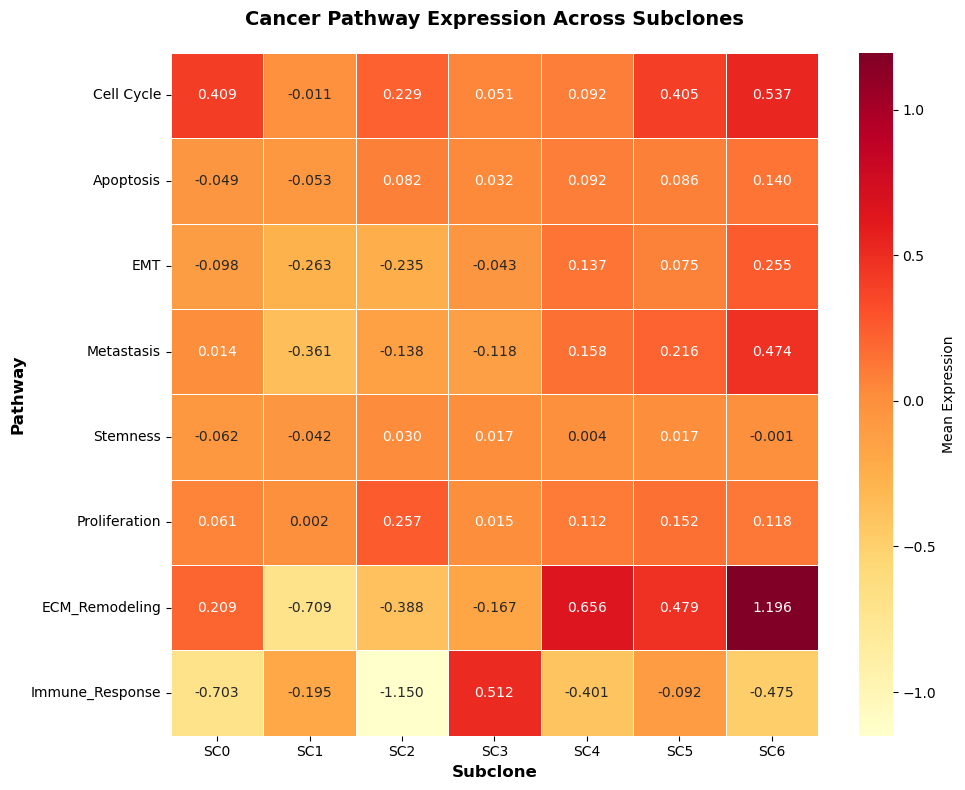


🎯 Creating pathway dot plot...


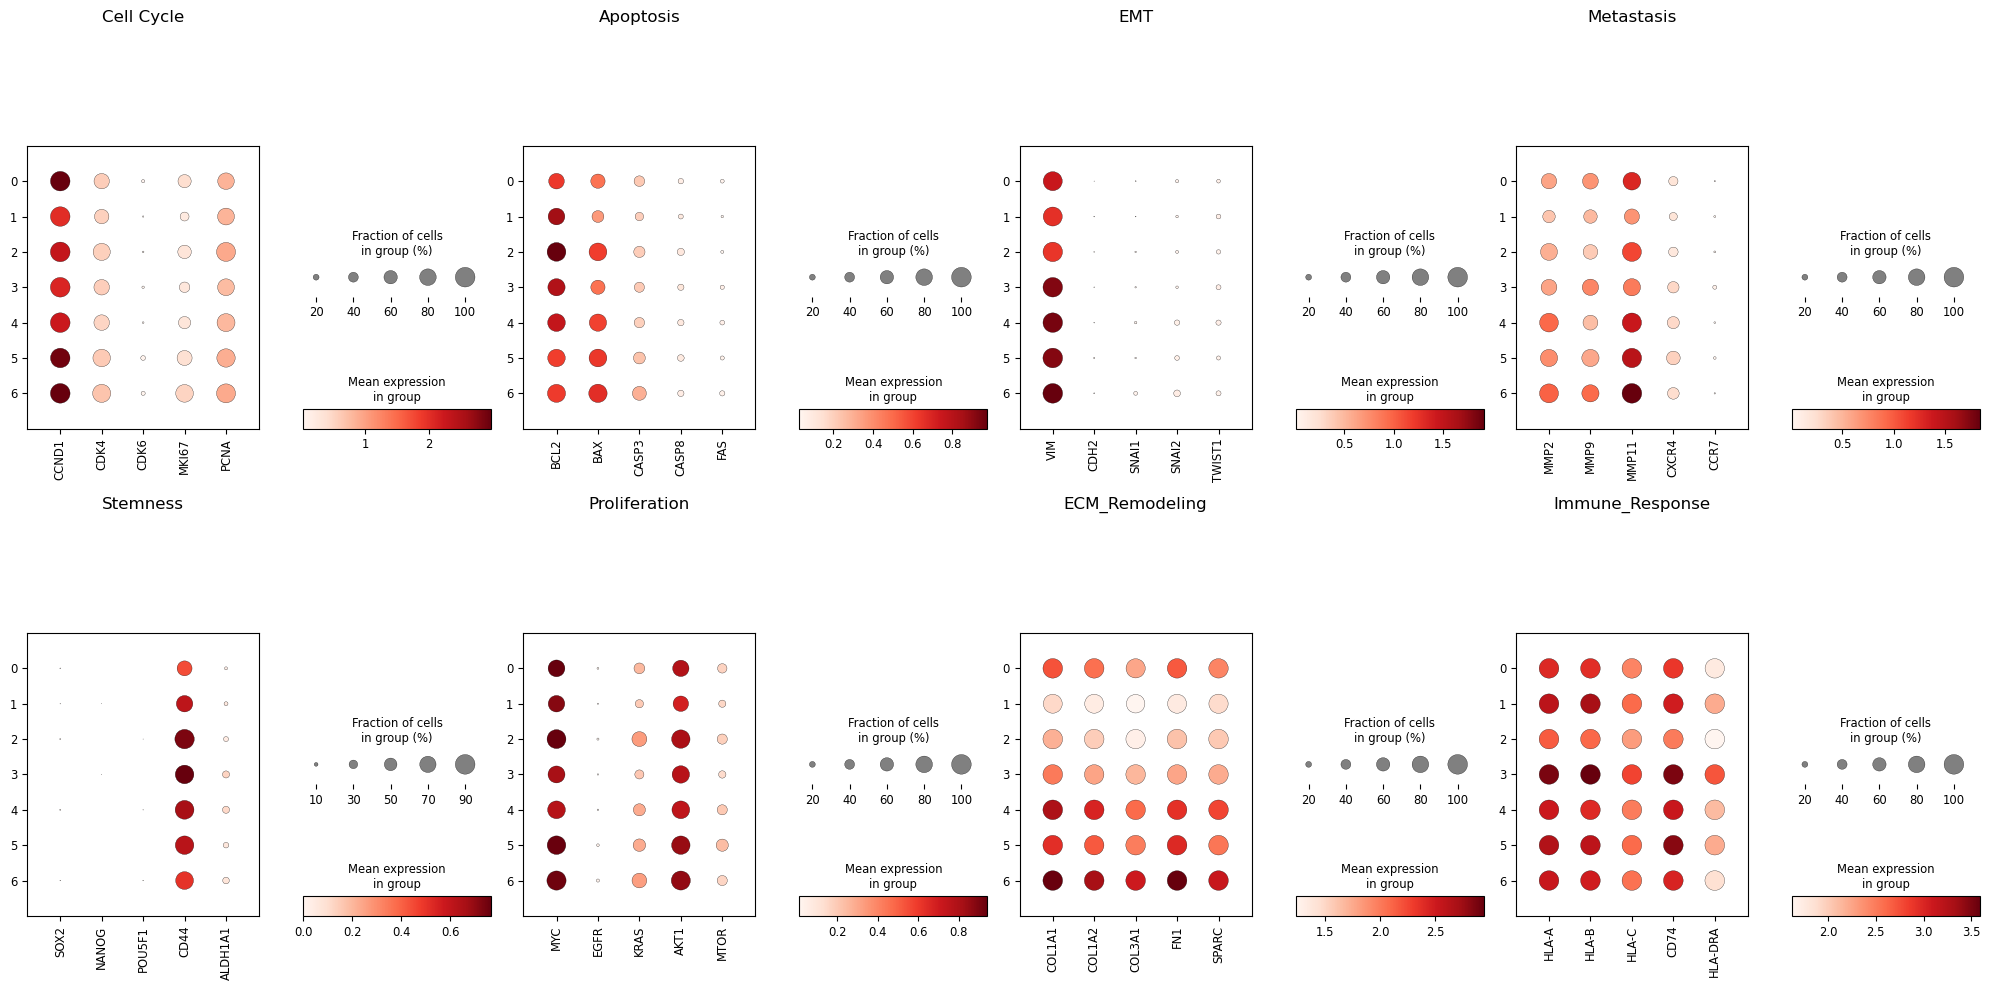


✓ Pathway analysis complete
✓ Files saved:
  - genes_for_enrichment_SC*.txt (for external tools)
  - pathway_*.png (individual pathways)
  - pathway_heatmap_comprehensive.png
  - pathway_dotplot_summary.png


In [31]:
print("\n" + "="*80)
print("ANALYSIS 3: FUNCTIONAL PATHWAY ENRICHMENT ANALYSIS")
print("="*80)

# Get top marker genes per subclone for pathway analysis
print("\n🧬 Extracting top marker genes for pathway enrichment...")

pathway_results = {}
for subclone in sorted(adata_cancer.obs['subclone'].unique()):
    markers = sc.get.rank_genes_groups_df(adata_cancer, group=subclone)
    # Get top 100 genes with significant p-values
    top_genes = markers[markers['pvals_adj'] < 0.05].head(100)['names'].tolist()
    pathway_results[subclone] = top_genes
    
    print(f"Subclone {subclone}: {len(top_genes)} significant marker genes")
    print(f"  Top 5: {', '.join(top_genes[:5])}")

# Save for external enrichment analysis
print("\n💾 Saving gene lists for external pathway tools...")
for subclone, genes in pathway_results.items():
    with open(f'../results/genes_for_enrichment_SC{subclone}.txt', 'w') as f:
        f.write('\n'.join(genes))

print("\n✓ Gene lists saved for pathway enrichment")
print("  → Use these files in:")
print("    • Enrichr: https://maayanlab.cloud/Enrichr/")
print("    • g:Profiler: https://biit.cs.ut.ee/gprofiler/")
print("    • DAVID: https://david.ncifcrf.gov/")

# Quick pathway analysis using known cancer gene sets
print("\n" + "="*80)
print("ANALYZING KNOWN CANCER PATHWAYS")
print("="*80)

cancer_pathways = {
    'Cell Cycle': ['CCND1', 'CDK4', 'CDK6', 'MKI67', 'PCNA', 'TOP2A', 'CCNE1', 'CCNA2'],
    'Apoptosis': ['BCL2', 'BAX', 'CASP3', 'CASP8', 'FAS', 'TNFRSF10B', 'BID', 'BCL2L1'],
    'EMT': ['VIM', 'CDH2', 'SNAI1', 'SNAI2', 'TWIST1', 'ZEB1', 'ZEB2', 'FN1'],
    'Metastasis': ['MMP2', 'MMP9', 'MMP11', 'CXCR4', 'CCR7', 'VEGFA', 'MMP14'],
    'Stemness': ['SOX2', 'NANOG', 'POU5F1', 'CD44', 'ALDH1A1', 'KLF4', 'MYC'],
    'Proliferation': ['MYC', 'EGFR', 'KRAS', 'AKT1', 'MTOR', 'PIK3CA', 'ERBB2'],
    'ECM_Remodeling': ['COL1A1', 'COL1A2', 'COL3A1', 'FN1', 'SPARC', 'POSTN', 'MMP11'],
    'Immune_Response': ['HLA-A', 'HLA-B', 'HLA-C', 'CD74', 'HLA-DRA', 'B2M', 'LYZ'],
}

# Check which pathways are enriched in each subclone
print("\n📊 Pathway Gene Availability:")
pathway_availability = {}

for pathway, genes in cancer_pathways.items():
    available = [g for g in genes if g in adata_cancer.var_names]
    pathway_availability[pathway] = available
    print(f"{pathway:<20} {len(available)}/{len(genes)} genes available: {', '.join(available)}")

# Calculate pathway scores for each subclone
print("\n" + "="*80)
print("PATHWAY EXPRESSION SCORES BY SUBCLONE")
print("="*80)

pathway_scores = {}

for pathway, genes in pathway_availability.items():
    if len(genes) > 0:
        print(f"\n{pathway}:")
        scores_per_subclone = {}
        
        for subclone in sorted(adata_cancer.obs['subclone'].unique()):
            mask = adata_cancer.obs['subclone'] == subclone
            # Calculate mean expression of pathway genes
            if hasattr(adata_cancer[:, genes].X, 'toarray'):
                expr = adata_cancer[mask, :][:, genes].X.toarray().mean()
            else:
                expr = adata_cancer[mask, :][:, genes].X.mean()
            scores_per_subclone[subclone] = expr
            print(f"  SC{subclone}: {expr:.3f}")
        
        pathway_scores[pathway] = scores_per_subclone

# Visualize pathway expression
print("\n📈 Creating pathway visualizations...")

# Create matrix plot for each pathway
for pathway, genes in pathway_availability.items():
    if len(genes) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        sc.pl.matrixplot(adata_cancer, genes, groupby='subclone',
                         dendrogram=False, cmap='Reds',
                         title=f'{pathway} Pathway Expression',
                         ax=ax, show=False)
        plt.tight_layout()
        plt.savefig(f'../results/pathway_{pathway.replace(" ", "_")}.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()

# Create comprehensive pathway heatmap
print("\n🔥 Creating comprehensive pathway heatmap...")

# Convert pathway scores to dataframe
pathway_df = pd.DataFrame(pathway_scores).T
pathway_df.columns = [f'SC{i}' for i in pathway_df.columns]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pathway_df, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Expression'},
            linewidths=0.5, ax=ax)
ax.set_xlabel('Subclone', fontsize=12, fontweight='bold')
ax.set_ylabel('Pathway', fontsize=12, fontweight='bold')
ax.set_title('Cancer Pathway Expression Across Subclones', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/pathway_heatmap_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Create dot plot for key pathways
print("\n🎯 Creating pathway dot plot...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (pathway, genes) in enumerate(pathway_availability.items()):
    if len(genes) > 0 and idx < 8:
        ax = axes[idx]
        sc.pl.dotplot(adata_cancer, genes[:5], groupby='subclone',
                      ax=ax, show=False, title=pathway)

plt.tight_layout()
plt.savefig('../results/pathway_dotplot_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Pathway analysis complete")
print("✓ Files saved:")
print("  - genes_for_enrichment_SC*.txt (for external tools)")
print("  - pathway_*.png (individual pathways)")
print("  - pathway_heatmap_comprehensive.png")
print("  - pathway_dotplot_summary.png")


ANALYSIS 4: SPATIAL DISTRIBUTION OF SUBCLONES

📍 Analyzing spatial distribution patterns...
Subclone 0:
  Centroid: (-15.44, -6.88)
  Compactness: 1.51
  Cells: 336
Subclone 1:
  Centroid: (1.91, 10.06)
  Compactness: 1.40
  Cells: 283
Subclone 2:
  Centroid: (-15.71, -0.15)
  Compactness: 1.61
  Cells: 269
Subclone 3:
  Centroid: (-1.39, 10.75)
  Compactness: 1.24
  Cells: 251
Subclone 4:
  Centroid: (-18.93, -2.83)
  Compactness: 1.05
  Cells: 152
Subclone 5:
  Centroid: (-18.11, -5.45)
  Compactness: 0.93
  Cells: 113
Subclone 6:
  Centroid: (-19.53, -6.68)
  Compactness: 1.22
  Cells: 104

🗺️ Creating spatial distribution visualizations...


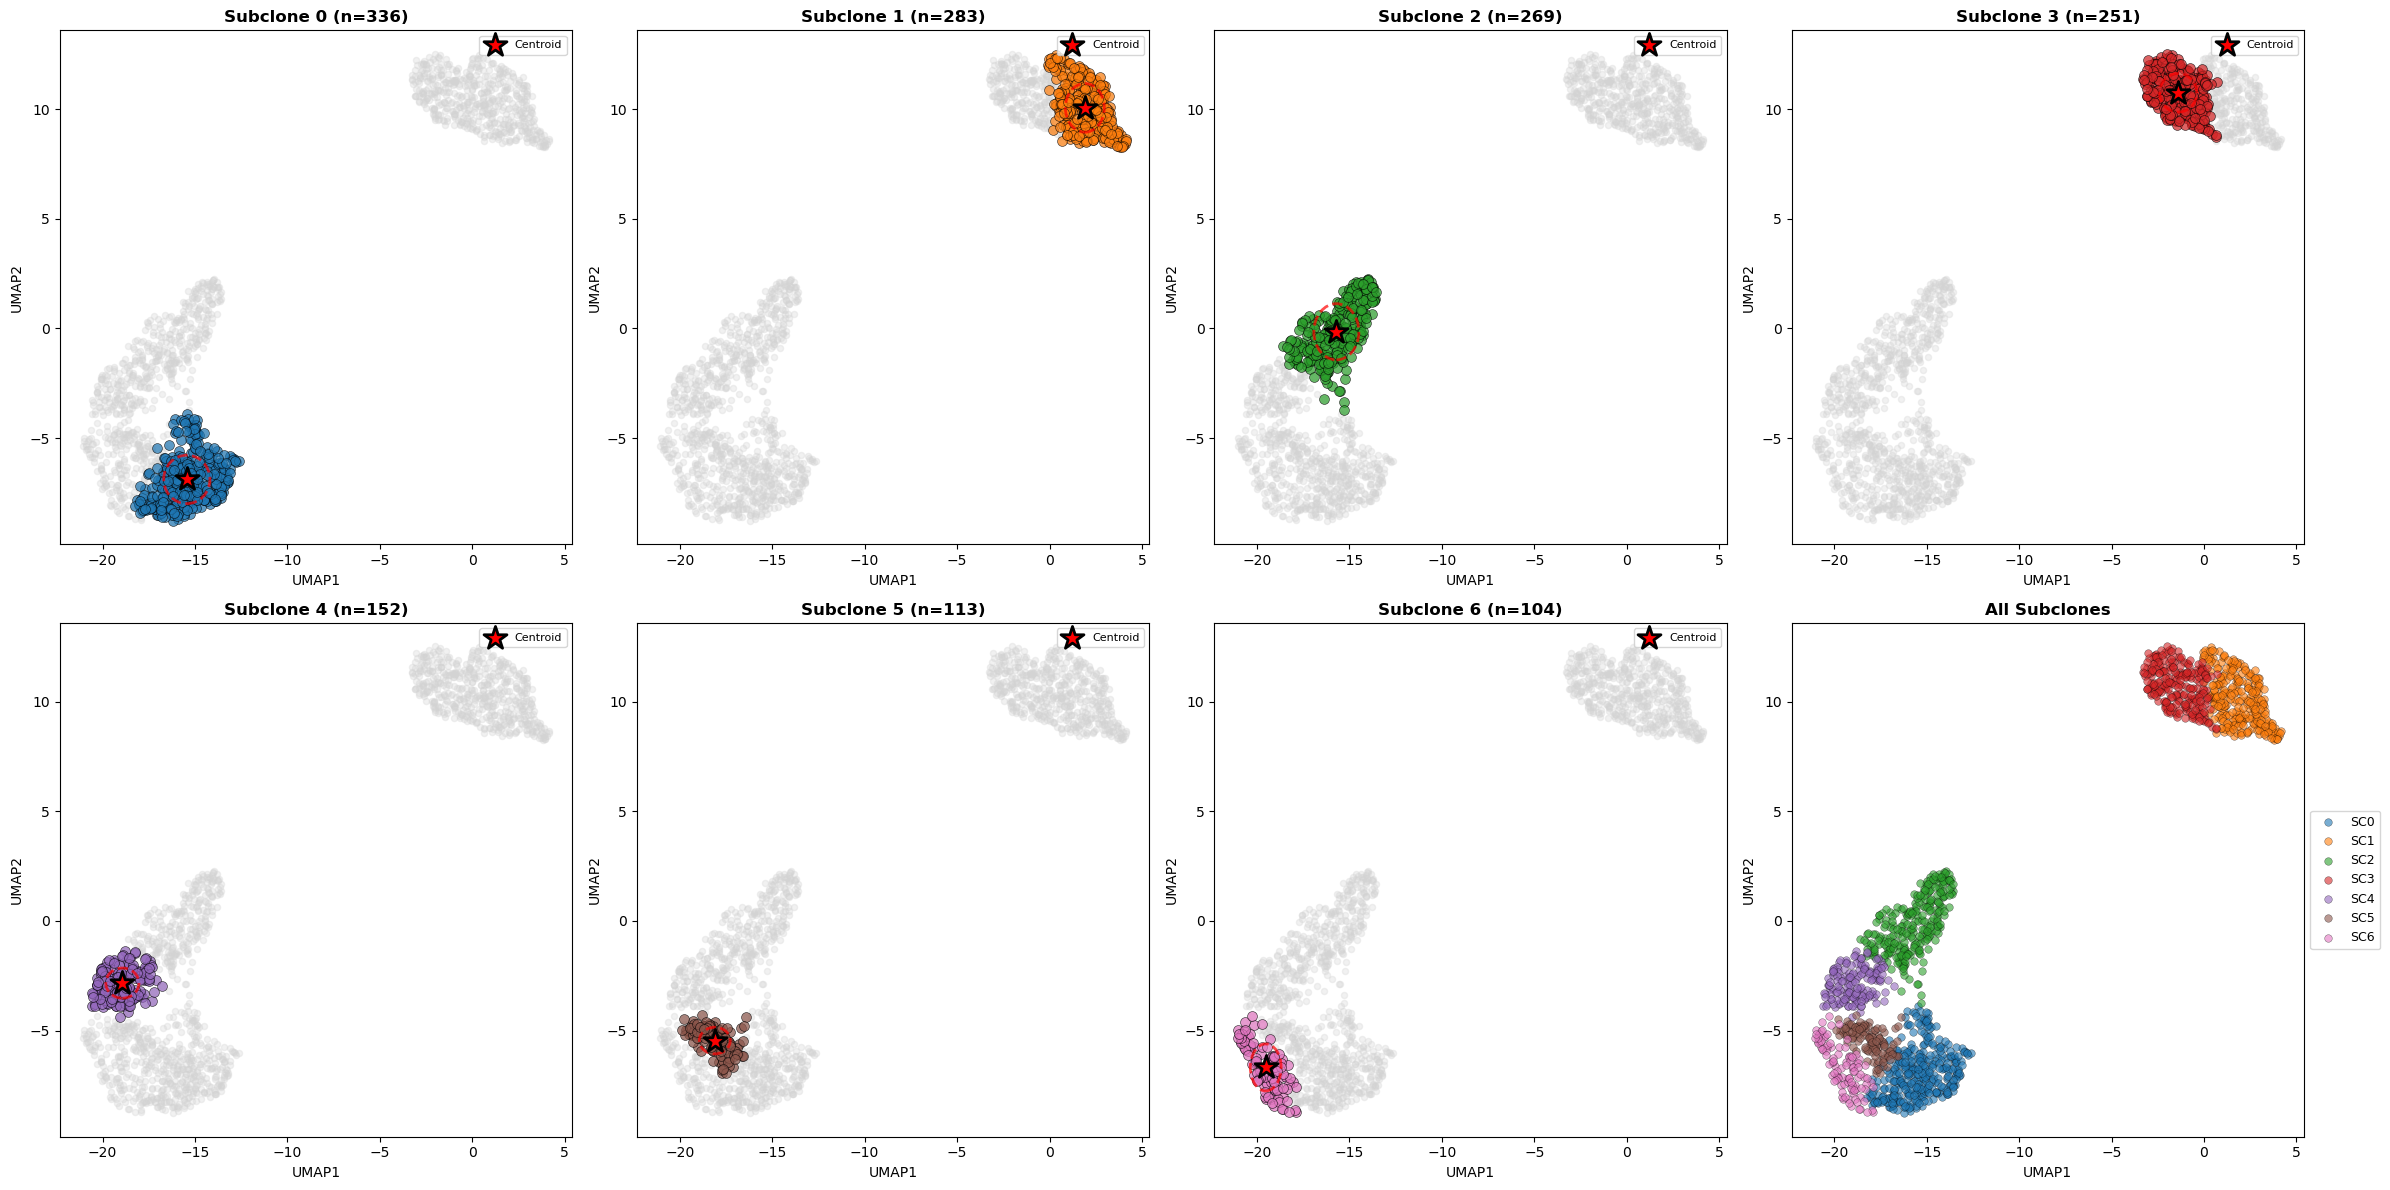


📊 Creating density maps...


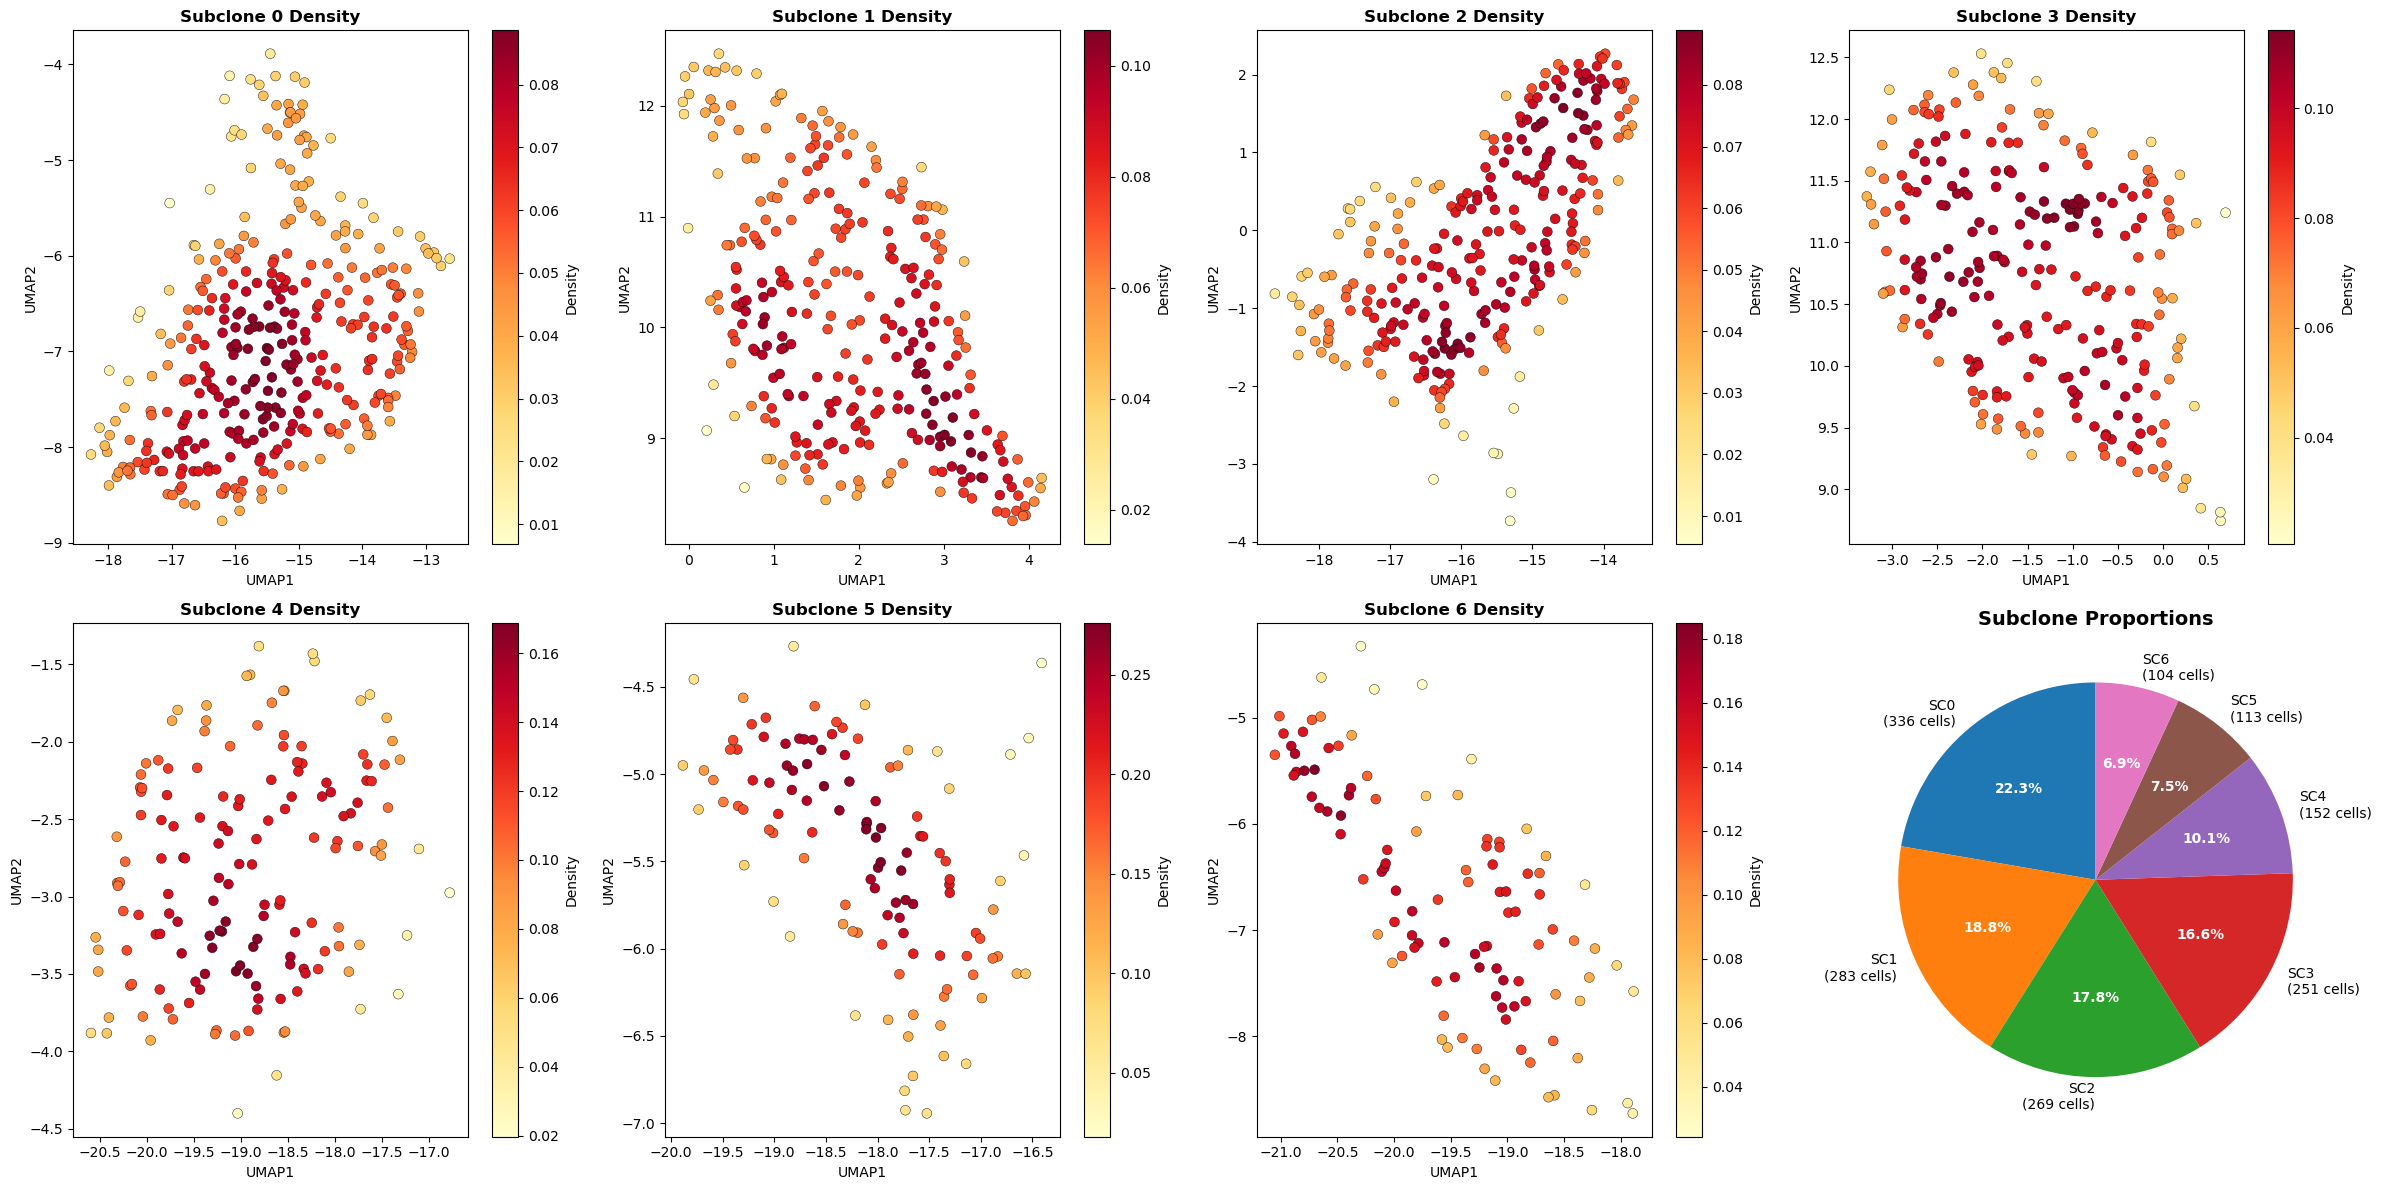


🔄 Analyzing spatial overlap between subclones...


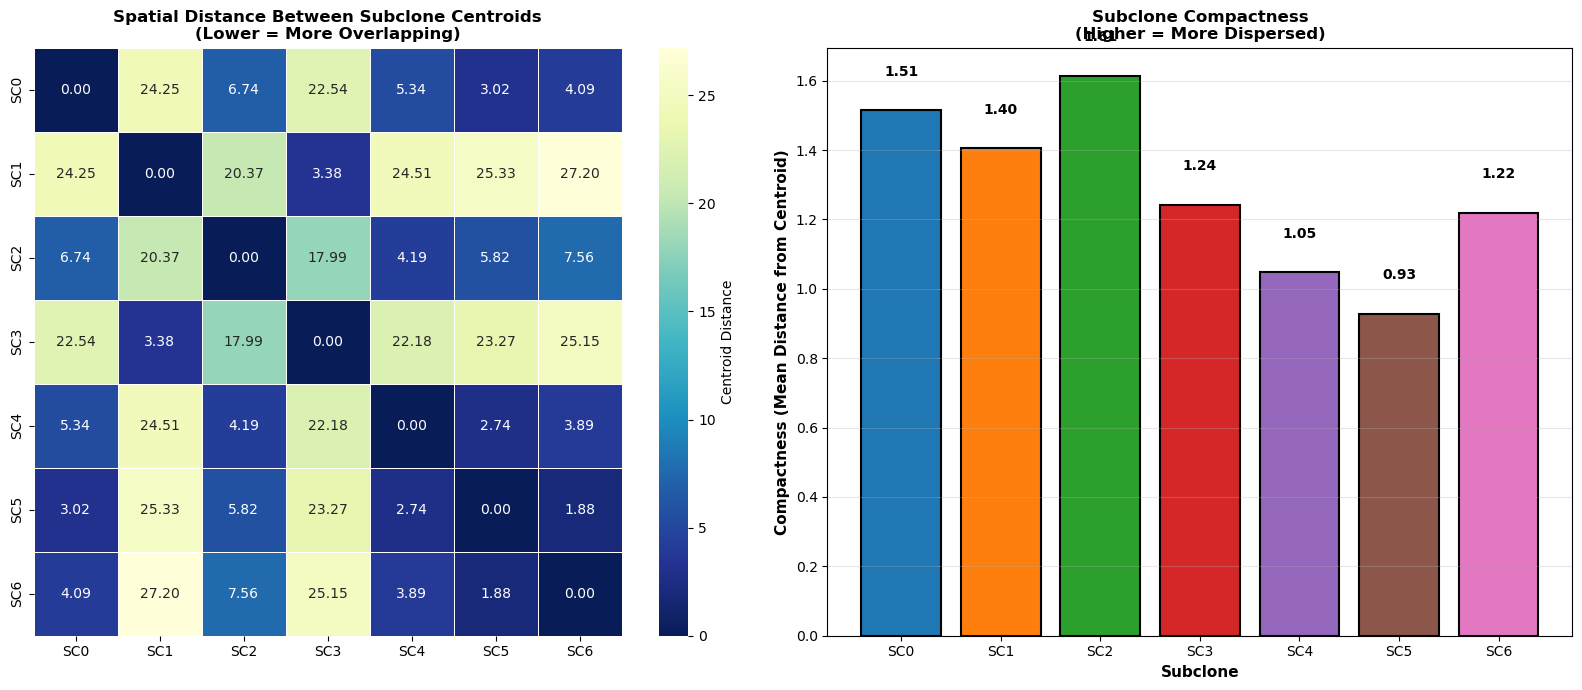


✓ Spatial distribution analysis complete
✓ Files saved:
  - spatial_distribution_subclones.png
  - subclone_density_maps.png
  - spatial_overlap_analysis.png


In [32]:
print("\n" + "="*80)
print("ANALYSIS 4: SPATIAL DISTRIBUTION OF SUBCLONES")
print("="*80)

from scipy.stats import gaussian_kde
from matplotlib.patches import Ellipse
from sklearn.covariance import EllipticEnvelope

# Get UMAP coordinates
umap_coords = adata_cancer.obsm['X_umap']

print("\n📍 Analyzing spatial distribution patterns...")

# Calculate spatial metrics for each subclone
spatial_metrics = {}

for subclone in sorted(adata_cancer.obs['subclone'].unique()):
    mask = adata_cancer.obs['subclone'] == subclone
    sc_coords = umap_coords[mask]
    
    # Calculate centroid
    centroid = sc_coords.mean(axis=0)
    
    # Calculate spread (standard deviation)
    spread = sc_coords.std(axis=0)
    
    # Calculate compactness (mean distance from centroid)
    distances = np.sqrt(((sc_coords - centroid)**2).sum(axis=1))
    compactness = distances.mean()
    
    spatial_metrics[subclone] = {
        'centroid': centroid,
        'spread': spread,
        'compactness': compactness,
        'n_cells': sum(mask)
    }
    
    print(f"Subclone {subclone}:")
    print(f"  Centroid: ({centroid[0]:.2f}, {centroid[1]:.2f})")
    print(f"  Compactness: {compactness:.2f}")
    print(f"  Cells: {sum(mask)}")

# Create comprehensive spatial visualization
print("\n🗺️ Creating spatial distribution visualizations...")

fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

# Color palette
colors = plt.cm.tab10(range(7))

# Individual subclone plots
for idx, subclone in enumerate(sorted(adata_cancer.obs['subclone'].unique())):
    ax = axes[idx]
    
    # Plot all cells in gray
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c='lightgray', s=20, alpha=0.3)
    
    # Highlight this subclone
    mask = adata_cancer.obs['subclone'] == subclone
    sc_coords = umap_coords[mask]
    ax.scatter(sc_coords[:, 0], sc_coords[:, 1], 
               c=[colors[idx]], s=50, alpha=0.7, 
               edgecolors='black', linewidth=0.5)
    
    # Mark centroid
    centroid = spatial_metrics[subclone]['centroid']
    ax.scatter(centroid[0], centroid[1], 
               c='red', s=300, marker='*', 
               edgecolors='black', linewidth=2,
               zorder=100, label='Centroid')
    
    # Add ellipse showing spread
    from matplotlib.patches import Ellipse
    spread = spatial_metrics[subclone]['spread']
    ellipse = Ellipse(centroid, width=spread[0]*2, height=spread[1]*2,
                     facecolor='none', edgecolor='red', 
                     linewidth=2, linestyle='--', alpha=0.7)
    ax.add_patch(ellipse)
    
    ax.set_title(f'Subclone {subclone} (n={spatial_metrics[subclone]["n_cells"]})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend(loc='upper right', fontsize=8)

# Summary plot with all subclones
ax = axes[7]
for idx, subclone in enumerate(sorted(adata_cancer.obs['subclone'].unique())):
    mask = adata_cancer.obs['subclone'] == subclone
    sc_coords = umap_coords[mask]
    ax.scatter(sc_coords[:, 0], sc_coords[:, 1],
               c=[colors[idx]], s=30, alpha=0.6,
               label=f'SC{subclone}', edgecolors='black', linewidth=0.3)

ax.set_title('All Subclones', fontsize=12, fontweight='bold')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

plt.tight_layout()
plt.savefig('../results/spatial_distribution_subclones.png', dpi=300, bbox_inches='tight')
plt.show()

# Create density maps
print("\n📊 Creating density maps...")

fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

for idx, subclone in enumerate(sorted(adata_cancer.obs['subclone'].unique())):
    ax = axes[idx]
    
    mask = adata_cancer.obs['subclone'] == subclone
    sc_coords = umap_coords[mask]
    
    # Create 2D density plot
    if len(sc_coords) > 10:  # Need enough points for KDE
        try:
            xy = np.vstack([sc_coords[:, 0], sc_coords[:, 1]])
            z = gaussian_kde(xy)(xy)
            
            scatter = ax.scatter(sc_coords[:, 0], sc_coords[:, 1],
                               c=z, s=50, cmap='YlOrRd', 
                               edgecolors='black', linewidth=0.3)
            plt.colorbar(scatter, ax=ax, label='Density')
        except:
            ax.scatter(sc_coords[:, 0], sc_coords[:, 1],
                      c=colors[idx], s=50, alpha=0.6)
    
    ax.set_title(f'Subclone {subclone} Density', fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

# Proportion pie chart
ax = axes[7]
subclone_counts = adata_cancer.obs['subclone'].value_counts().sort_index()
wedges, texts, autotexts = ax.pie(subclone_counts.values,
                                   labels=[f'SC{i}\n({subclone_counts[i]} cells)' 
                                          for i in subclone_counts.index],
                                   colors=colors[:len(subclone_counts)],
                                   autopct='%1.1f%%',
                                   startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax.set_title('Subclone Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/subclone_density_maps.png', dpi=300, bbox_inches='tight')
plt.show()

# Spatial overlap analysis
print("\n🔄 Analyzing spatial overlap between subclones...")

from scipy.spatial.distance import cdist

# Calculate pairwise spatial overlap
overlap_matrix = np.zeros((7, 7))

for i in range(7):
    mask_i = adata_cancer.obs['subclone'] == str(i)
    coords_i = umap_coords[mask_i]
    centroid_i = coords_i.mean(axis=0)
    
    for j in range(7):
        if i != j:
            mask_j = adata_cancer.obs['subclone'] == str(j)
            coords_j = umap_coords[mask_j]
            centroid_j = coords_j.mean(axis=0)
            
            # Calculate centroid distance
            distance = np.sqrt(((centroid_i - centroid_j)**2).sum())
            overlap_matrix[i, j] = distance

# Visualize spatial relationships
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Centroid distance matrix
sns.heatmap(overlap_matrix, annot=True, fmt='.2f', cmap='YlGnBu_r',
            xticklabels=[f'SC{i}' for i in range(7)],
            yticklabels=[f'SC{i}' for i in range(7)],
            ax=ax1, cbar_kws={'label': 'Centroid Distance'},
            square=True, linewidths=0.5)
ax1.set_title('Spatial Distance Between Subclone Centroids\n(Lower = More Overlapping)', 
              fontsize=12, fontweight='bold')

# Compactness comparison
ax2.bar(range(7), [spatial_metrics[str(i)]['compactness'] for i in range(7)],
        color=colors[:7], edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Subclone', fontsize=11, fontweight='bold')
ax2.set_ylabel('Compactness (Mean Distance from Centroid)', 
               fontsize=11, fontweight='bold')
ax2.set_title('Subclone Compactness\n(Higher = More Dispersed)', 
              fontsize=12, fontweight='bold')
ax2.set_xticks(range(7))
ax2.set_xticklabels([f'SC{i}' for i in range(7)])
ax2.grid(axis='y', alpha=0.3)

# Add values on bars
for i, val in enumerate([spatial_metrics[str(i)]['compactness'] for i in range(7)]):
    ax2.text(i, val + 0.1, f'{val:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/spatial_overlap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Spatial distribution analysis complete")
print("✓ Files saved:")
print("  - spatial_distribution_subclones.png")
print("  - subclone_density_maps.png")
print("  - spatial_overlap_analysis.png")


ANALYSIS 5: EVOLUTIONARY RATE ANALYSIS

🧬 Calculating number of differentially expressed genes between subclones...

Comparing SC0 vs SC1...
  Upregulated in SC0: 1697
  Downregulated in SC0: 861
  Total DE genes: 2558

Comparing SC0 vs SC2...
  Upregulated in SC0: 282
  Downregulated in SC0: 2164
  Total DE genes: 2446

Comparing SC0 vs SC3...
  Upregulated in SC0: 899
  Downregulated in SC0: 1096
  Total DE genes: 1995

Comparing SC0 vs SC4...
  Upregulated in SC0: 230
  Downregulated in SC0: 1186
  Total DE genes: 1416

Comparing SC0 vs SC5...
  Upregulated in SC0: 1
  Downregulated in SC0: 415
  Total DE genes: 416

Comparing SC0 vs SC6...
  Upregulated in SC0: 0
  Downregulated in SC0: 793
  Total DE genes: 793

Comparing SC1 vs SC2...
  Upregulated in SC1: 387
  Downregulated in SC1: 3190
  Total DE genes: 3577

Comparing SC1 vs SC3...
  Upregulated in SC1: 13
  Downregulated in SC1: 301
  Total DE genes: 314

Comparing SC1 vs SC4...
  Upregulated in SC1: 452
  Downregulated in 

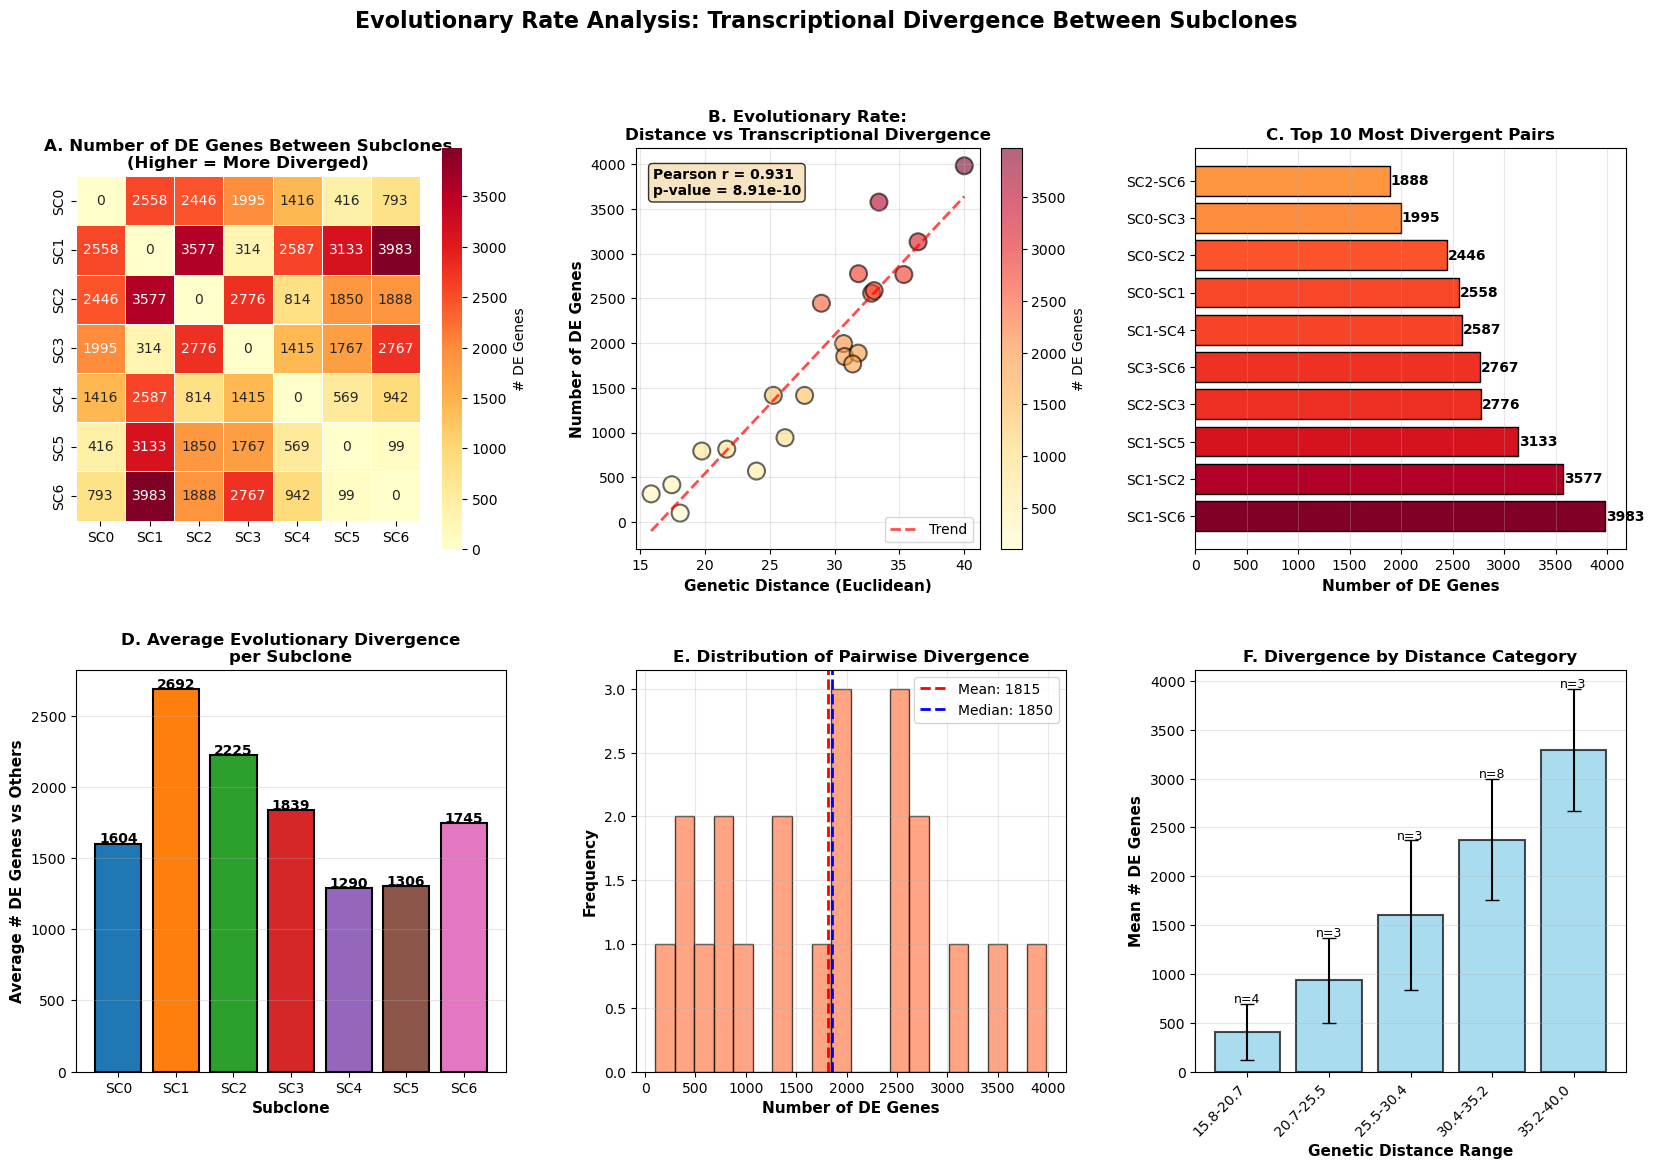


✓ Evolutionary rate analysis complete
✓ File saved: evolutionary_rate_analysis.png
✓ File saved: pairwise_de_gene_counts.csv


In [33]:
print("\n" + "="*80)
print("ANALYSIS 5: EVOLUTIONARY RATE ANALYSIS")
print("="*80)

print("\n🧬 Calculating number of differentially expressed genes between subclones...")

# Calculate pairwise DE genes
pairwise_de_genes = {}
de_details = {}

subclones = sorted(adata_cancer.obs['subclone'].unique())

for i, sc1 in enumerate(subclones):
    for sc2 in subclones[i+1:]:
        print(f"\nComparing SC{sc1} vs SC{sc2}...")
        
        # Subset to these two subclones
        adata_pair = adata_cancer[adata_cancer.obs['subclone'].isin([sc1, sc2])].copy()
        
        # Find DE genes
        sc.tl.rank_genes_groups(adata_pair, 'subclone', method='wilcoxon', 
                                groups=[sc1], reference=sc2)
        
        # Get results for both directions
        de_genes_sc1 = sc.get.rank_genes_groups_df(adata_pair, group=sc1)
        
        # Count significant DE genes (adjusted p-value < 0.05, log2FC > 0.5)
        sig_sc1_up = sum((de_genes_sc1['pvals_adj'] < 0.05) & 
                         (de_genes_sc1['logfoldchanges'] > 0.5))
        sig_sc1_down = sum((de_genes_sc1['pvals_adj'] < 0.05) & 
                           (de_genes_sc1['logfoldchanges'] < -0.5))
        
        total_de = sig_sc1_up + sig_sc1_down
        
        pair_name = f'SC{sc1}-SC{sc2}'
        pairwise_de_genes[pair_name] = total_de
        de_details[pair_name] = {
            'up_in_sc1': sig_sc1_up,
            'down_in_sc1': sig_sc1_down,
            'total': total_de
        }
        
        print(f"  Upregulated in SC{sc1}: {sig_sc1_up}")
        print(f"  Downregulated in SC{sc1}: {sig_sc1_down}")
        print(f"  Total DE genes: {total_de}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY: Pairwise DE Gene Counts")
print("="*80)
print(f"{'Comparison':<15} {'Total DE':<10} {'Up in 1st':<12} {'Down in 1st'}")
print("-"*50)

for pair in sorted(pairwise_de_genes.items(), key=lambda x: x[1], reverse=True):
    pair_name, n_genes = pair
    details = de_details[pair_name]
    print(f"{pair_name:<15} {details['total']:<10} {details['up_in_sc1']:<12} {details['down_in_sc1']}")

# Create DE genes matrix
de_matrix = np.zeros((7, 7))
for pair, n_genes in pairwise_de_genes.items():
    parts = pair.split('-')
    sc1, sc2 = parts[0].replace('SC', ''), parts[1].replace('SC', '')
    idx1, idx2 = int(sc1), int(sc2)
    de_matrix[idx1, idx2] = n_genes
    de_matrix[idx2, idx1] = n_genes

print("\n📊 Creating evolutionary rate visualizations...")

# Create comprehensive figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Panel A: DE genes heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(de_matrix, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=[f'SC{i}' for i in range(7)],
            yticklabels=[f'SC{i}' for i in range(7)],
            ax=ax1, square=True, cbar_kws={'label': '# DE Genes'},
            linewidths=0.5)
ax1.set_title('A. Number of DE Genes Between Subclones\n(Higher = More Diverged)',
              fontsize=12, fontweight='bold')

# Panel B: DE genes vs genetic distance
ax2 = fig.add_subplot(gs[0, 1])
# Flatten matrices for correlation
genetic_dist_flat = []
de_genes_flat = []

for i in range(7):
    for j in range(i+1, 7):
        genetic_dist_flat.append(distance_matrix[i, j])
        de_genes_flat.append(de_matrix[i, j])

scatter = ax2.scatter(genetic_dist_flat, de_genes_flat,
                     s=150, alpha=0.6, c=de_genes_flat,
                     cmap='YlOrRd', edgecolors='black', linewidth=1.5)
ax2.set_xlabel('Genetic Distance (Euclidean)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of DE Genes', fontsize=11, fontweight='bold')
ax2.set_title('B. Evolutionary Rate:\nDistance vs Transcriptional Divergence',
              fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# Add trendline
from scipy.stats import pearsonr
from numpy.polynomial import Polynomial
p = Polynomial.fit(genetic_dist_flat, de_genes_flat, 1)
x_line = np.linspace(min(genetic_dist_flat), max(genetic_dist_flat), 100)
y_line = p(x_line)
ax2.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, label='Trend')

# Add correlation
r, p_val = pearsonr(genetic_dist_flat, de_genes_flat)
ax2.text(0.05, 0.95, f'Pearson r = {r:.3f}\np-value = {p_val:.2e}',
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax2.legend()

plt.colorbar(scatter, ax=ax2, label='# DE Genes')

# Panel C: Top divergent pairs
ax3 = fig.add_subplot(gs[0, 2])
top_pairs = sorted(pairwise_de_genes.items(), key=lambda x: x[1], reverse=True)[:10]
pair_labels = [p[0] for p in top_pairs]
pair_values = [p[1] for p in top_pairs]

bars = ax3.barh(range(len(pair_labels)), pair_values,
                color=plt.cm.YlOrRd(np.array(pair_values)/max(pair_values)),
                edgecolor='black', linewidth=1)
ax3.set_yticks(range(len(pair_labels)))
ax3.set_yticklabels(pair_labels)
ax3.set_xlabel('Number of DE Genes', fontsize=11, fontweight='bold')
ax3.set_title('C. Top 10 Most Divergent Pairs',
              fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

for i, val in enumerate(pair_values):
    ax3.text(val + 10, i, str(int(val)), va='center', fontweight='bold')

# Panel D: Divergence by original cluster
ax4 = fig.add_subplot(gs[1, 0])

# Calculate average divergence for each subclone
avg_divergence = {}
for i in range(7):
    avg_div = np.mean([de_matrix[i, j] for j in range(7) if i != j])
    avg_divergence[i] = avg_div

colors_bar = plt.cm.tab10(range(7))
bars = ax4.bar(range(7), [avg_divergence[i] for i in range(7)],
               color=colors_bar, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Subclone', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average # DE Genes vs Others', fontsize=11, fontweight='bold')
ax4.set_title('D. Average Evolutionary Divergence\nper Subclone',
              fontsize=12, fontweight='bold')
ax4.set_xticks(range(7))
ax4.set_xticklabels([f'SC{i}' for i in range(7)])
ax4.grid(axis='y', alpha=0.3)

for i, val in enumerate([avg_divergence[i] for i in range(7)]):
    ax4.text(i, val + 5, f'{val:.0f}', ha='center', fontweight='bold')

# Panel E: Distribution of DE genes
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(de_genes_flat, bins=20, color='coral', edgecolor='black', alpha=0.7)
ax5.axvline(np.mean(de_genes_flat), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(de_genes_flat):.0f}')
ax5.axvline(np.median(de_genes_flat), color='blue', linestyle='--',
            linewidth=2, label=f'Median: {np.median(de_genes_flat):.0f}')
ax5.set_xlabel('Number of DE Genes', fontsize=11, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax5.set_title('E. Distribution of Pairwise Divergence',
              fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# Panel F: Genetic distance vs DE genes (different view)
ax6 = fig.add_subplot(gs[1, 2])

# Create bins for genetic distance
dist_bins = pd.cut(genetic_dist_flat, bins=5)
df_plot = pd.DataFrame({'distance': genetic_dist_flat, 
                        'de_genes': de_genes_flat,
                        'dist_bin': dist_bins})
df_grouped = df_plot.groupby('dist_bin')['de_genes'].agg(['mean', 'std', 'count'])

x_pos = range(len(df_grouped))
ax6.bar(x_pos, df_grouped['mean'], yerr=df_grouped['std'],
        color='skyblue', edgecolor='black', linewidth=1.5,
        capsize=5, alpha=0.7)
ax6.set_xticks(x_pos)
ax6.set_xticklabels([f'{interval.left:.1f}-{interval.right:.1f}' 
                      for interval in df_grouped.index], rotation=45, ha='right')
ax6.set_xlabel('Genetic Distance Range', fontsize=11, fontweight='bold')
ax6.set_ylabel('Mean # DE Genes', fontsize=11, fontweight='bold')
ax6.set_title('F. Divergence by Distance Category',
              fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# Add sample sizes
for i, (idx, row) in enumerate(df_grouped.iterrows()):
    ax6.text(i, row['mean'] + row['std'] + 10, f'n={int(row["count"])}',
            ha='center', fontsize=9)

plt.suptitle('Evolutionary Rate Analysis: Transcriptional Divergence Between Subclones',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('../results/evolutionary_rate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evolutionary rate analysis complete")
print("✓ File saved: evolutionary_rate_analysis.png")

# Save DE gene counts
de_summary = pd.DataFrame(pairwise_de_genes.items(), columns=['Comparison', 'DE_Genes'])
de_summary = de_summary.sort_values('DE_Genes', ascending=False)
de_summary.to_csv('../results/pairwise_de_gene_counts.csv', index=False)
print("✓ File saved: pairwise_de_gene_counts.csv")